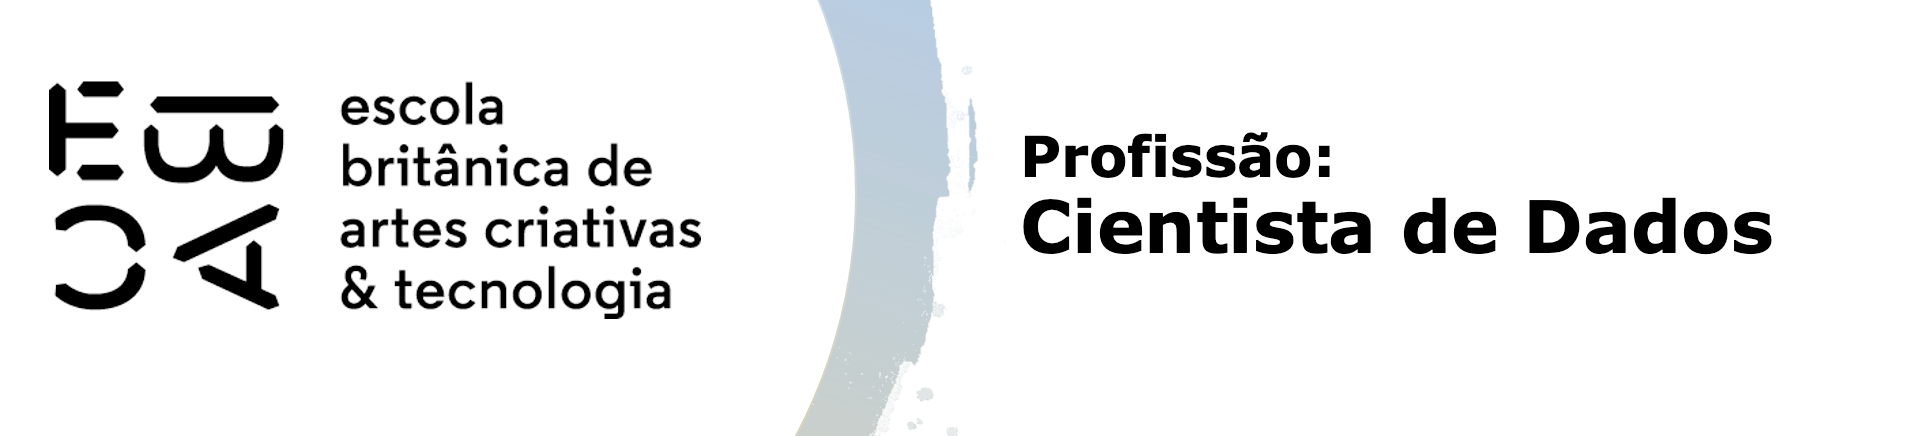

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
# Converta a coluna data_ref para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Encontre a data mais recente
data_max = df['data_ref'].max()

# Defina o período para os últimos três meses
data_inicio_validacao = data_max - pd.DateOffset(months=3)

# Separe os dados de treinamento e validação
df_treino = df[df['data_ref'] < data_inicio_validacao]
df_validacao = df[df['data_ref'] >= data_inicio_validacao]

# Verifique o número de registros em cada conjunto
print(f"Treinamento: {df_treino.shape[0]} registros")
print(f"Validação: {df_validacao.shape[0]} registros")

Treinamento: 550000 registros
Validação: 200000 registros


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [3]:
# Descrição da Base de Dados 
# Número total de registros
total_linhas = df.shape[0]
print(f"Número total de linhas: {total_linhas}")

# Número de linhas para cada mês
linhas_por_mes = df['data_ref'].dt.to_period('M').value_counts().sort_index()
print("\nNúmero de linhas por mês:")
print(linhas_por_mes)



Número total de linhas: 750000

Número de linhas por mês:
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64


In [4]:
# Análise Descritiva Univariada

# Variáveis Qualitativas
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
for var in variaveis_qualitativas:
    print(f"\nAnálise da variável qualitativa {var}:")
    print(df[var].value_counts())
    print(df[var].value_counts(normalize=True) * 100)  # Frequência relativa em porcentagem

# Variáveis Quantitativas
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
for var in variaveis_quantitativas:
    print(f"\nAnálise da variável quantitativa {var}:")
    print(df[var].describe())


Análise da variável qualitativa sexo:
sexo
F    504580
M    245420
Name: count, dtype: int64
sexo
F    67.277333
M    32.722667
Name: proportion, dtype: float64

Análise da variável qualitativa posse_de_veiculo:
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64
posse_de_veiculo
N    61.060533
S    38.939467
Name: proportion, dtype: float64

Análise da variável qualitativa posse_de_imovel:
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64
posse_de_imovel
S    67.158933
N    32.841067
Name: proportion, dtype: float64

Análise da variável qualitativa tipo_renda:
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64
tipo_renda
Assalariado         51.432000
Empresário          23.028267
Pensionista         16.835333
Servidor público     8.656267
Bolsista             0.048133
Name: proportion, dtype: float64

Análise da variável qualitativa e

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


Tabela de contingência entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 371028  133552
M                  86926  158494



Tabela de contingência entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                156662  347918
M                 89646  155774



Tabela de contingência entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774       108016             47034
M                150345         0       58938        18249             17888



Tabela de contingência entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                5403  342166            591             137952   
M                317

tipo_residencia   Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
tipo_renda                                                             
Assalariado          6408  341268        21238         2539     2089   
Bolsista                0     361            0            0        0   
Empresário           2545  154727         8511          307     1449   
Pensionista           627  121280           89            0      640   
Servidor público      769   56658         3394          444     1217   

tipo_residencia   Governamental  
tipo_renda                       
Assalariado               12198  
Bolsista                      0  
Empresário                 5173  
Pensionista                3629  
Servidor público           2440  



Tabela de contingência entre educacao e sexo:
sexo                      F       M
educacao                           
Fundamental            5403    3172
Médio                342166  164670
Pós graduação           591     221
Superior completo    137952 

estado_civil     Casado  Separado  Solteiro  União  Viúvo
tipo_residencia                                          
Aluguel            6590       250      2834    581     94
Casa             475505     38093     78845  51686  30165
Com os pais       21593      2229      5637   3667    106
Comunitário        2566       128       363     45    188
Estúdio            3786       455       590    564      0
Governamental     16432      1416      3390   1142   1060




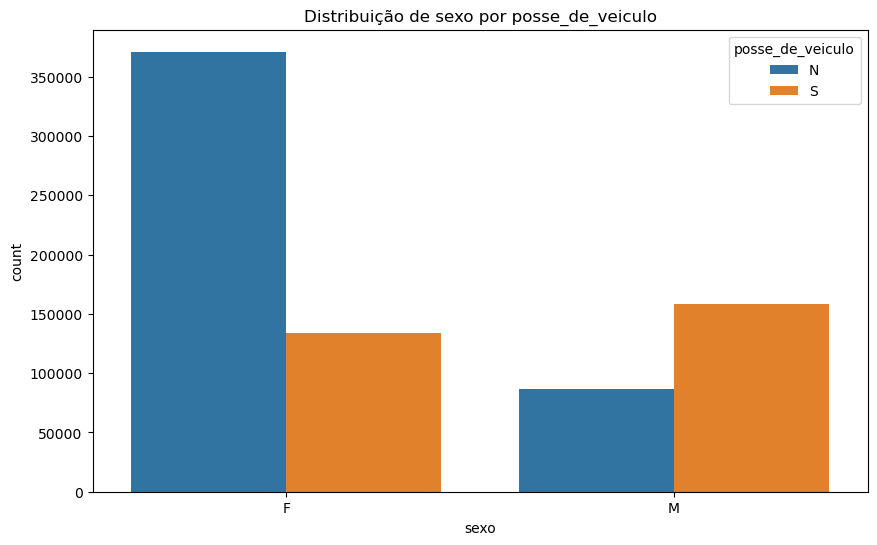

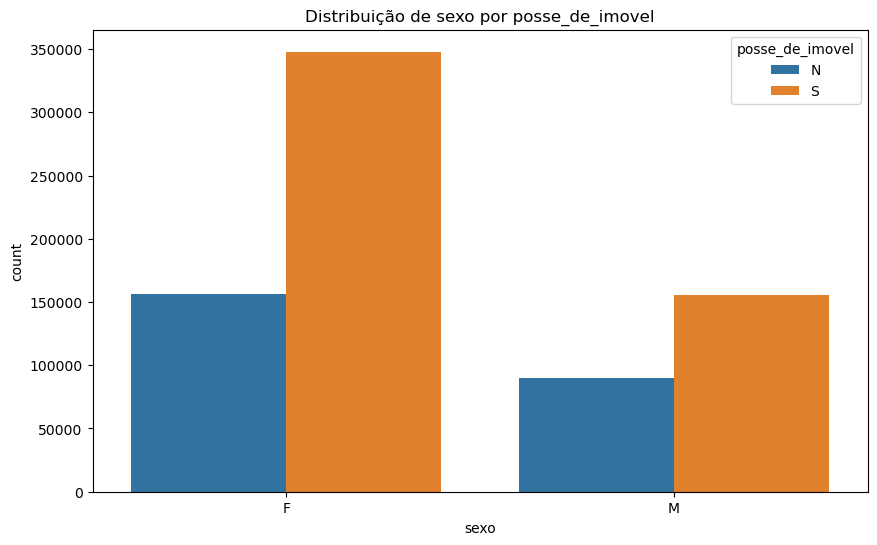

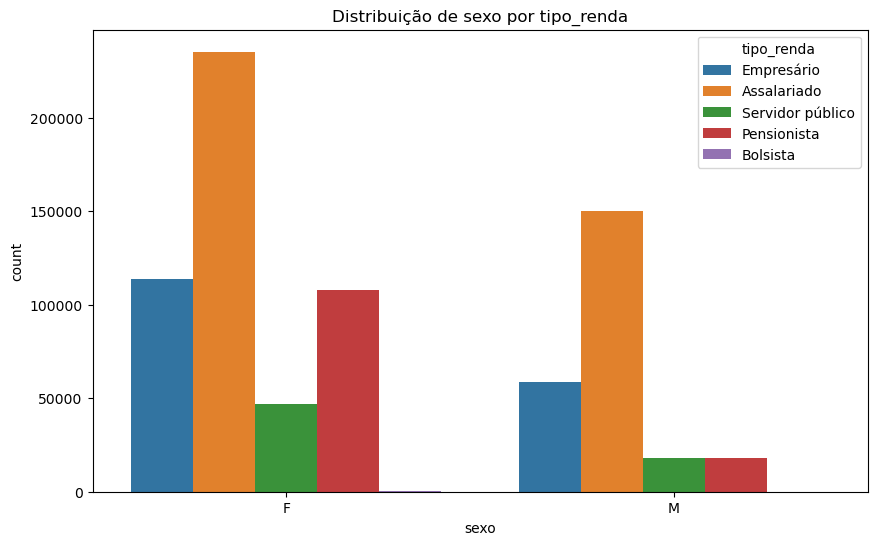

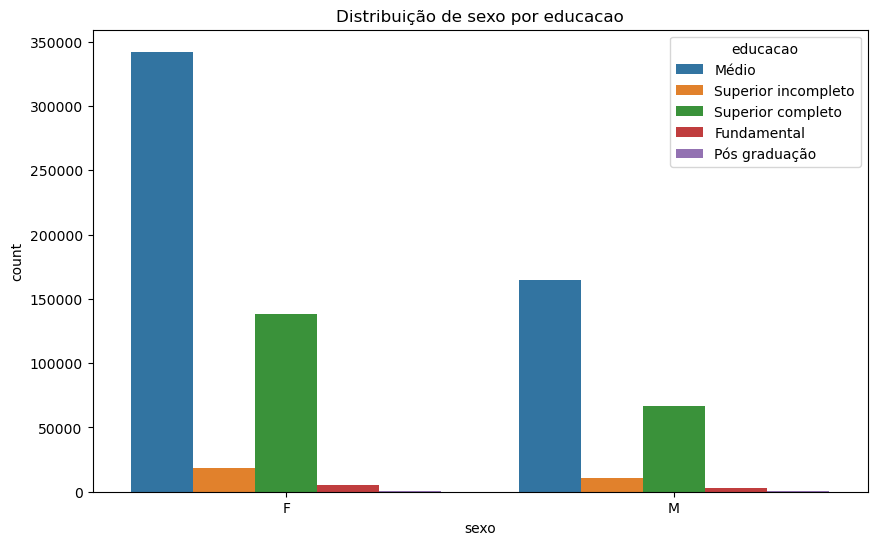

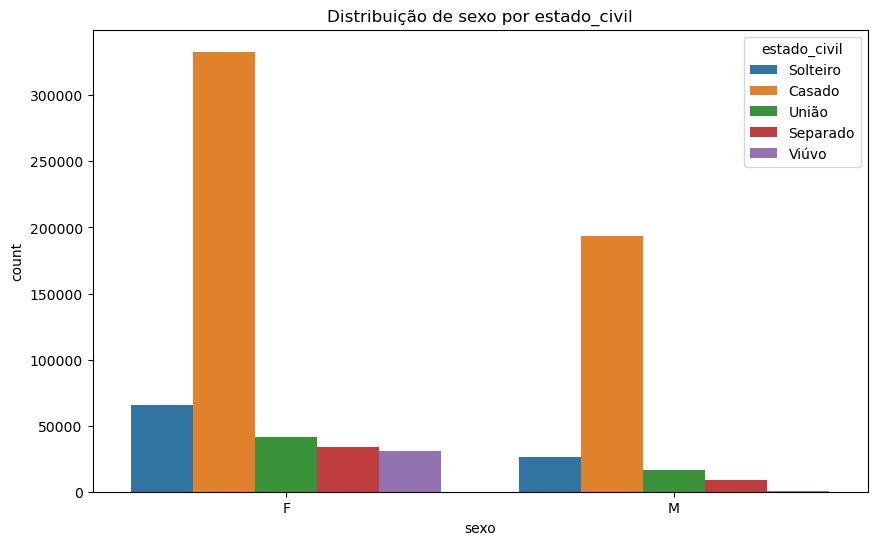

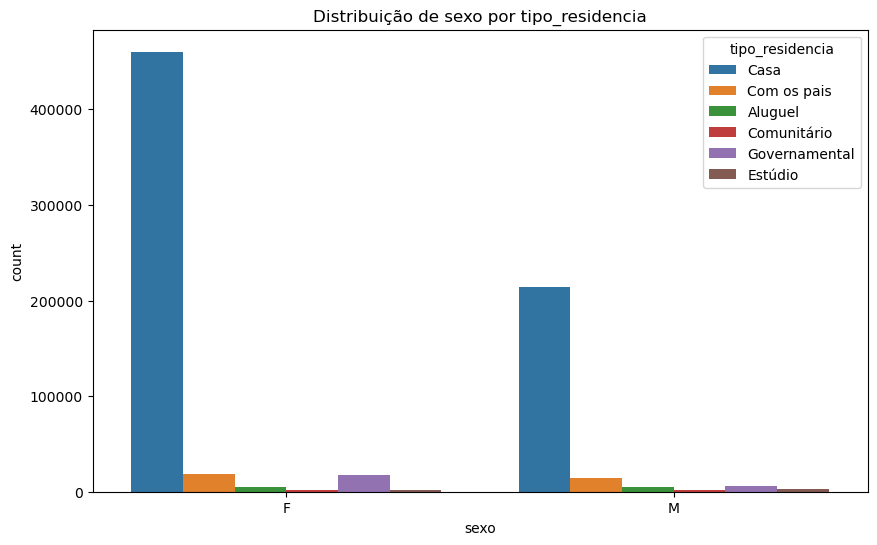

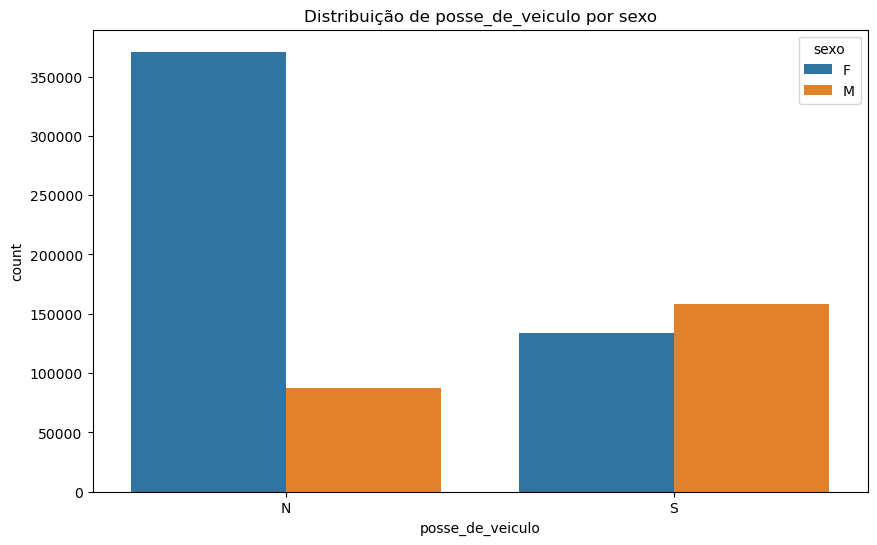

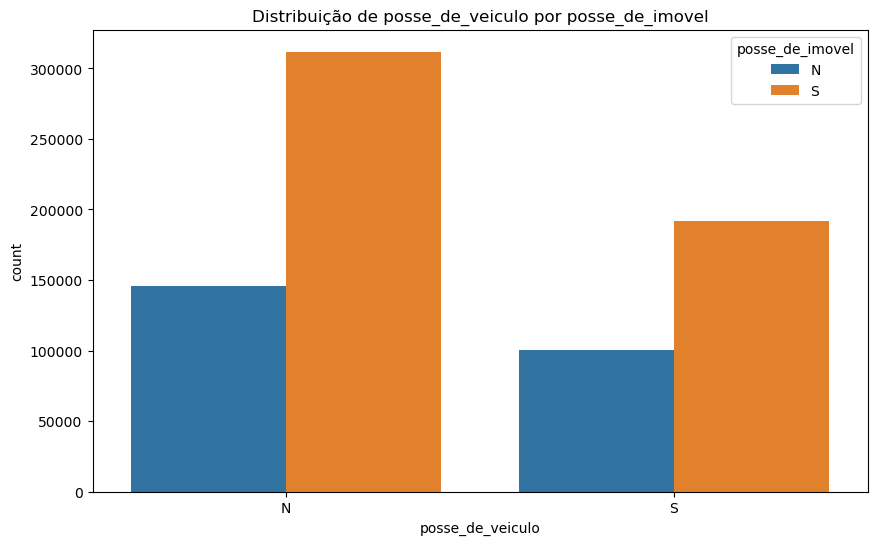

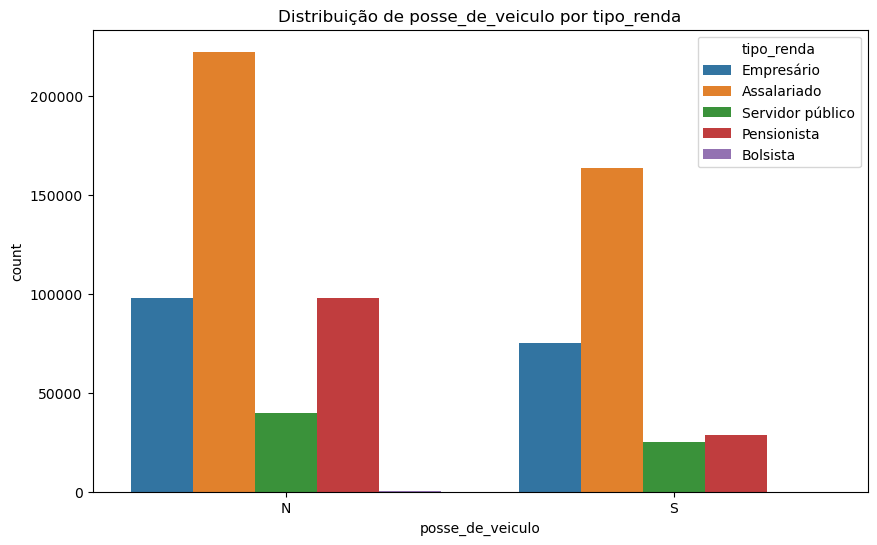

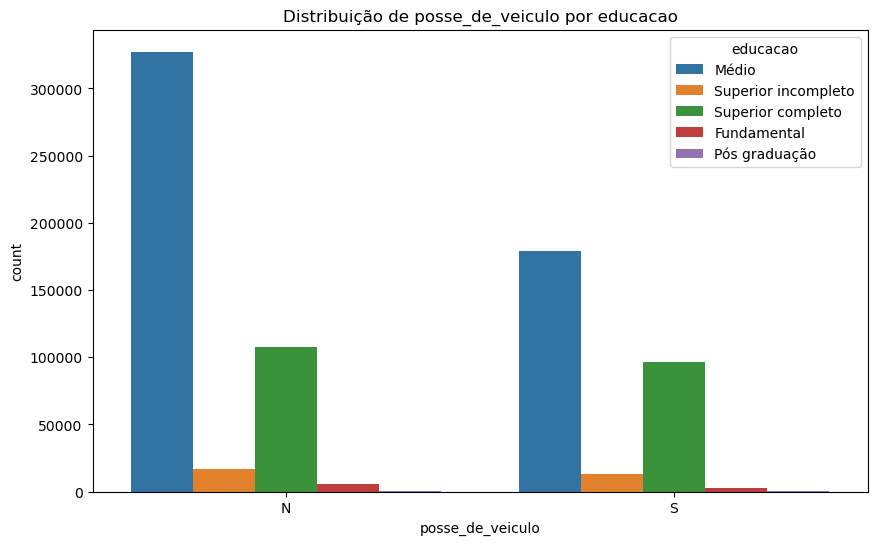

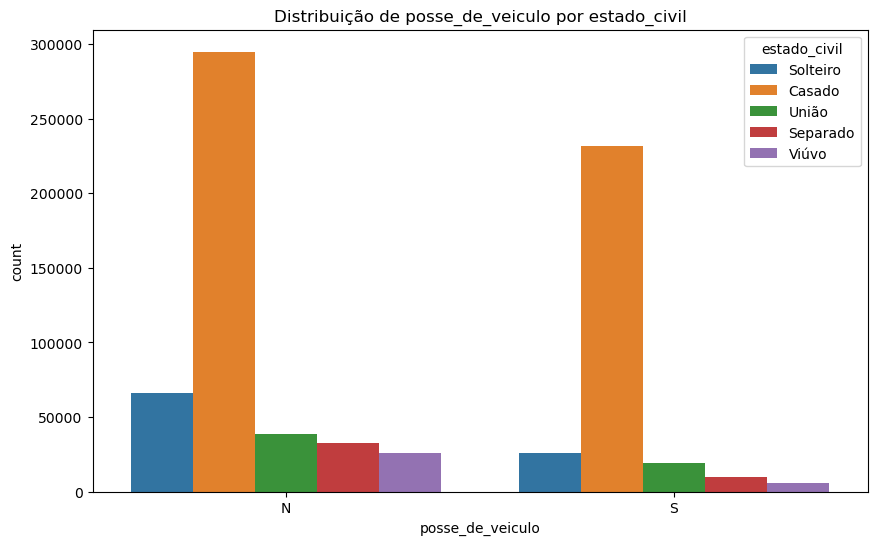

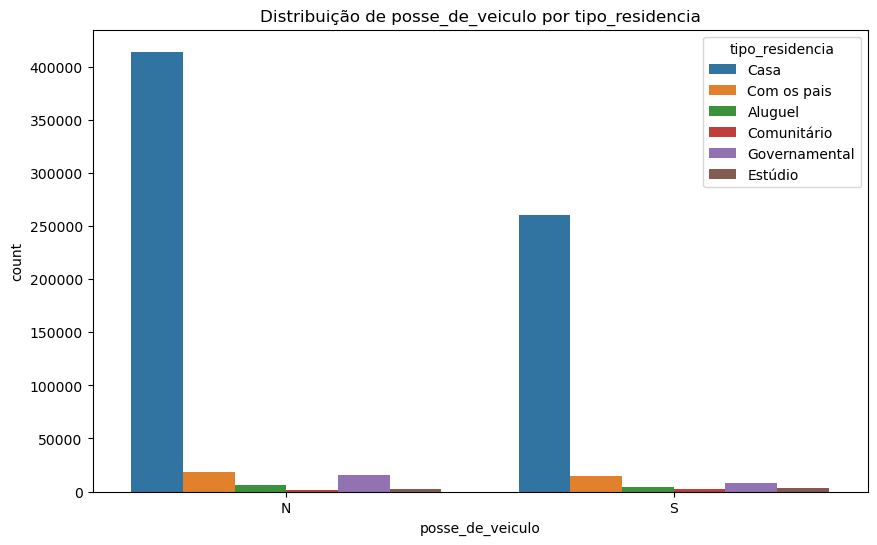

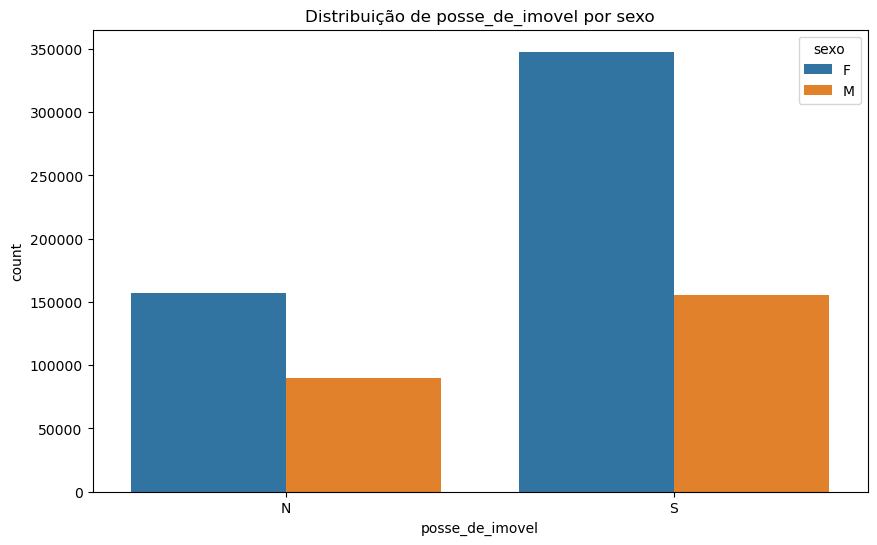

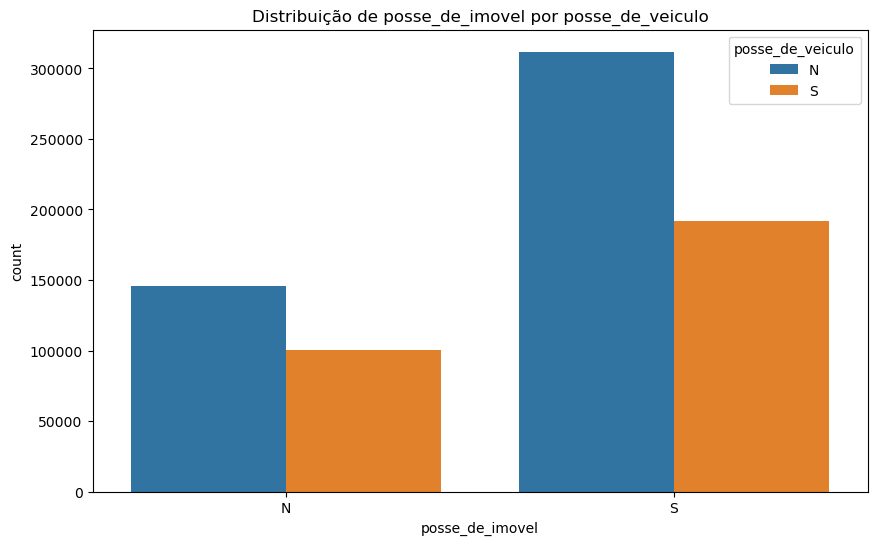

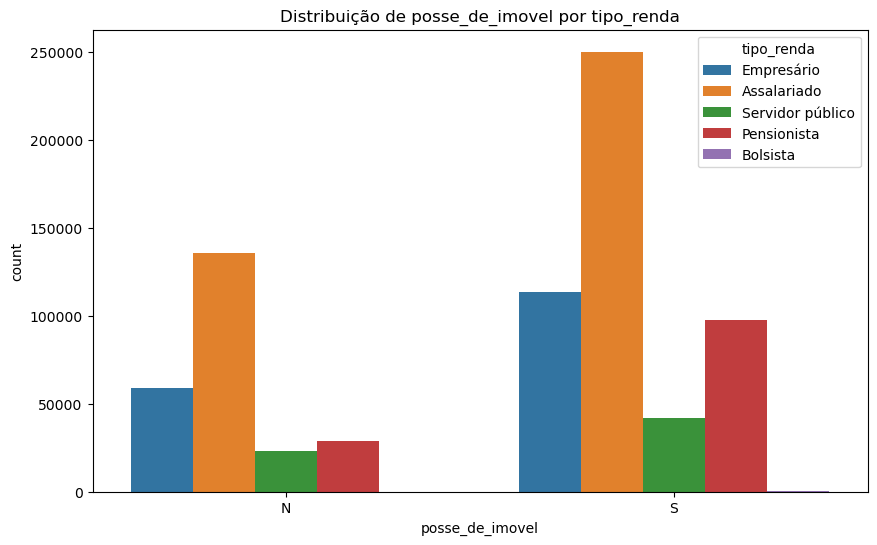

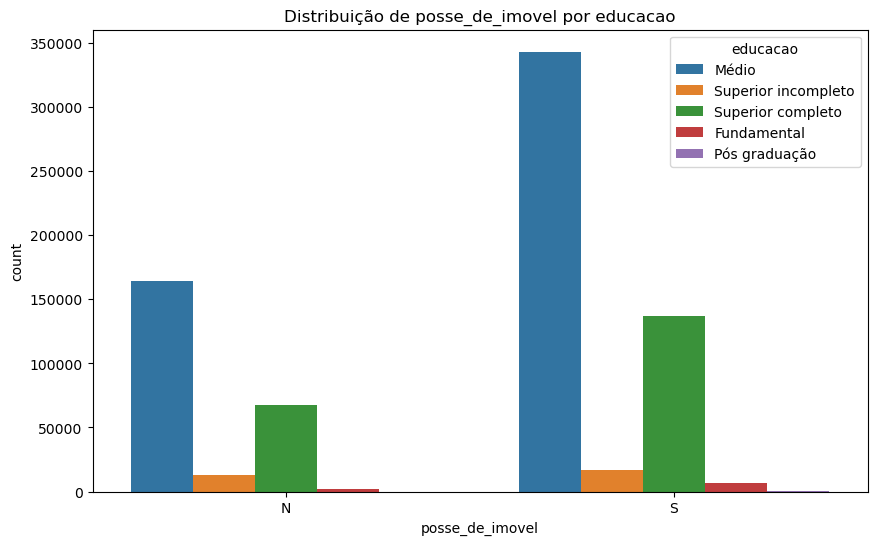

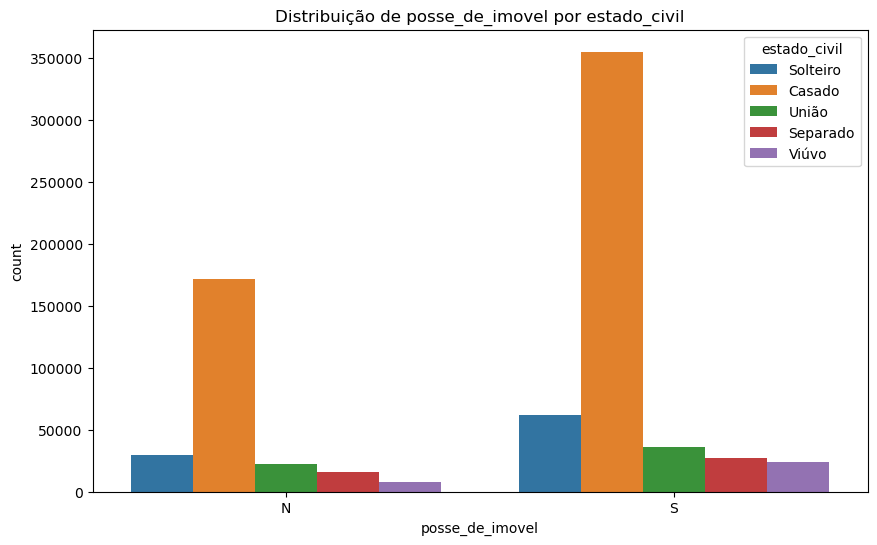

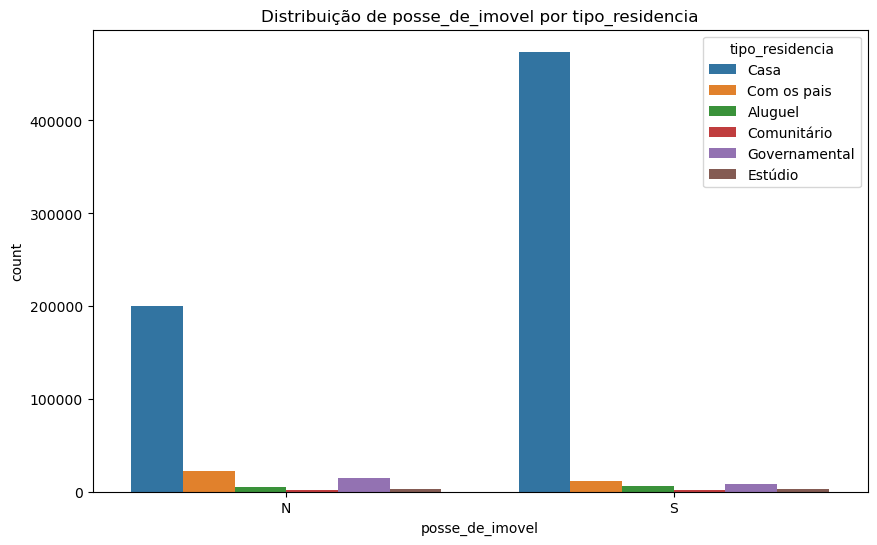

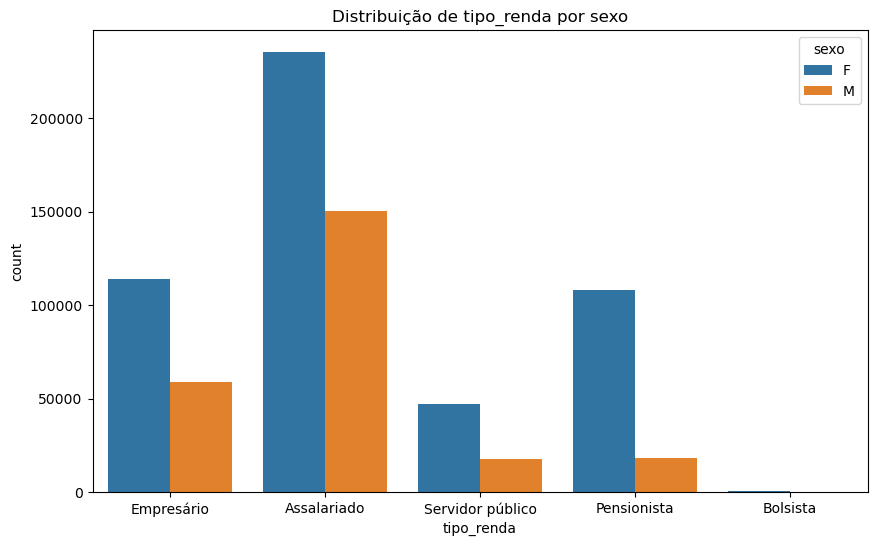

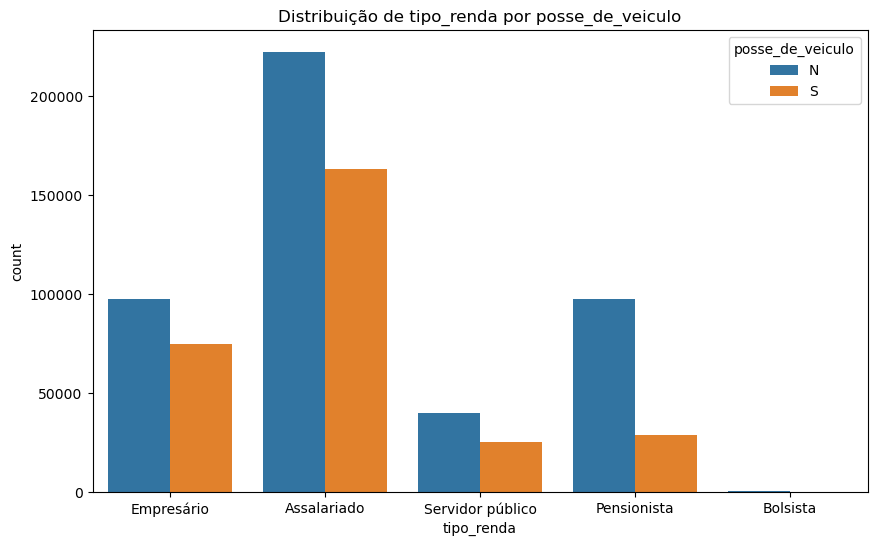

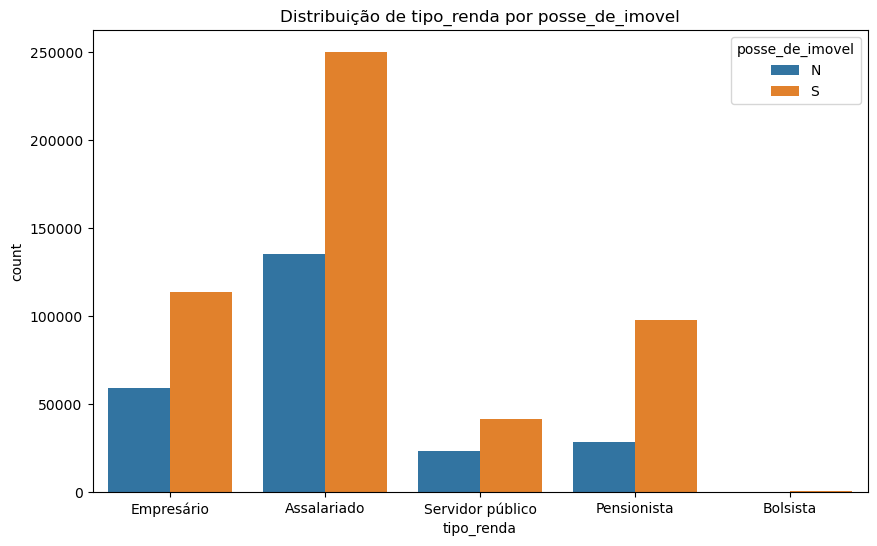

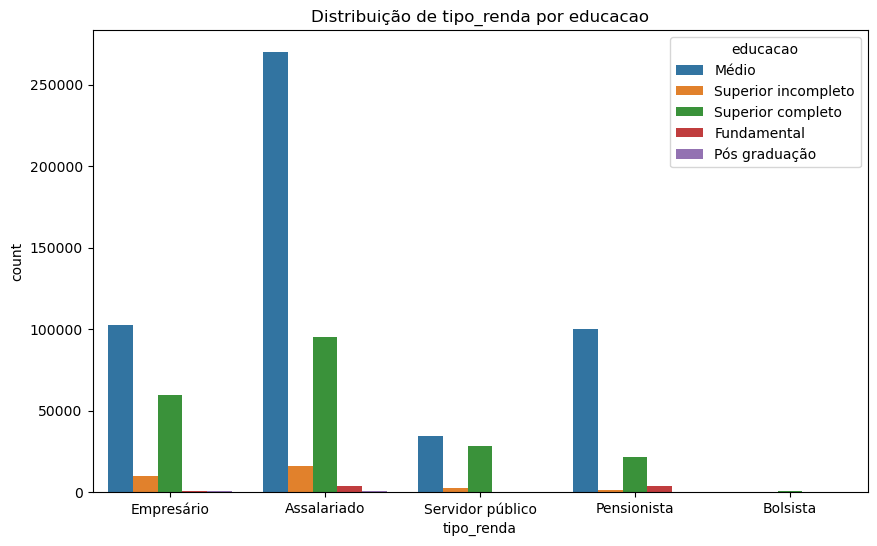

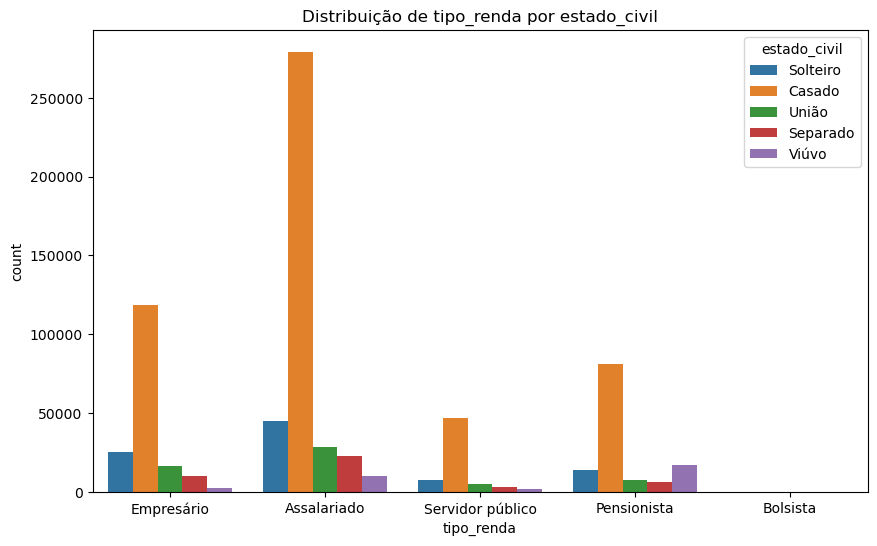

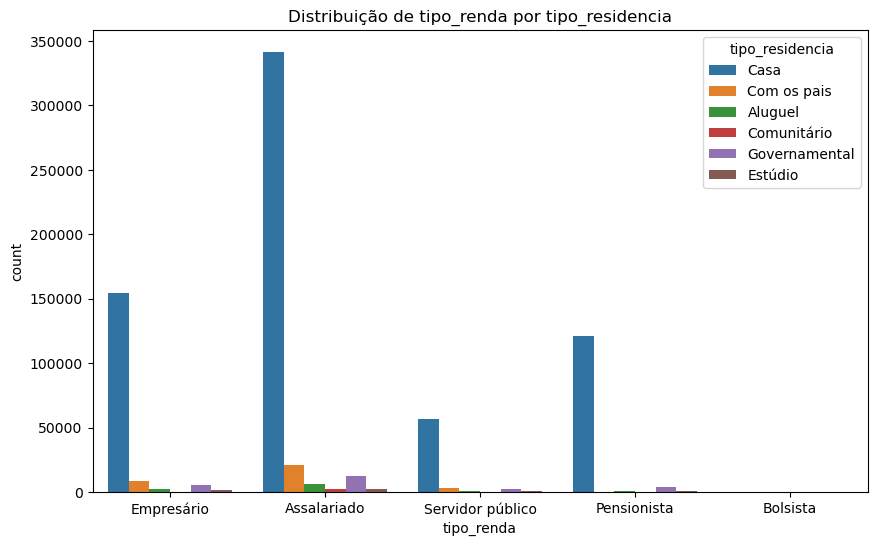

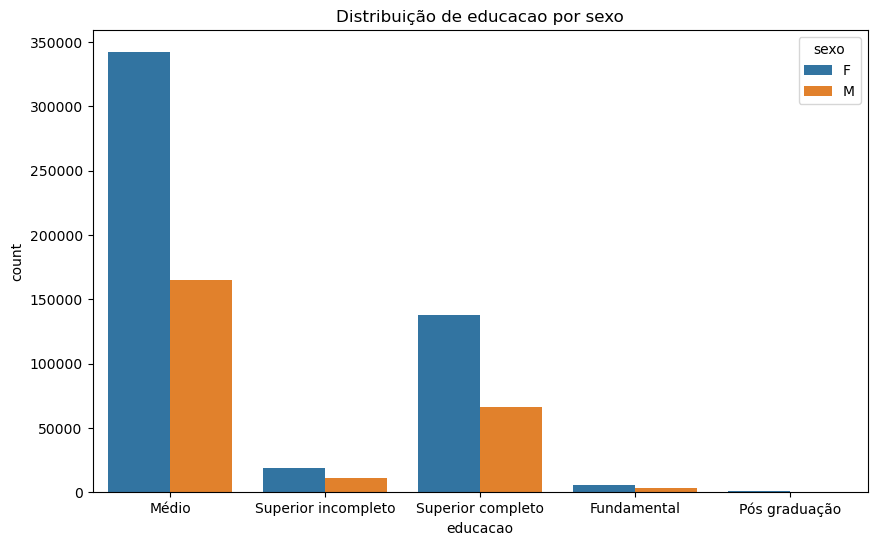

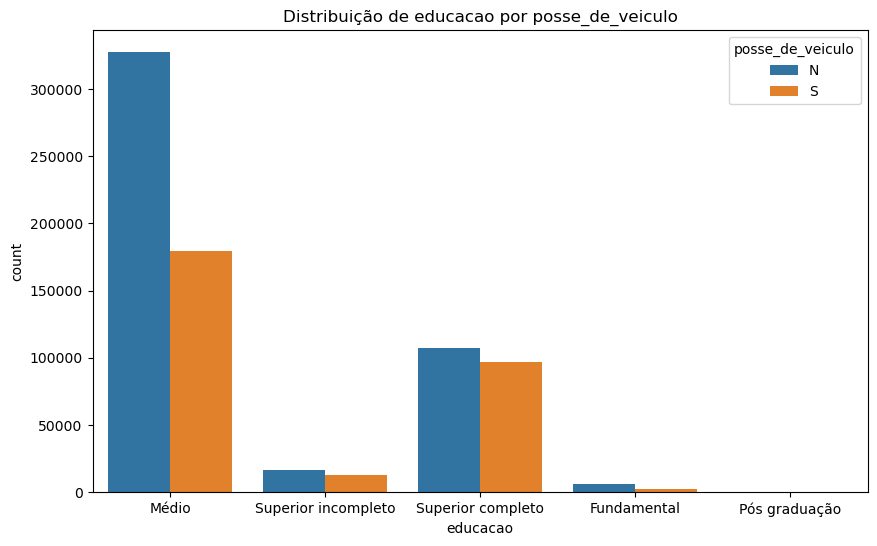

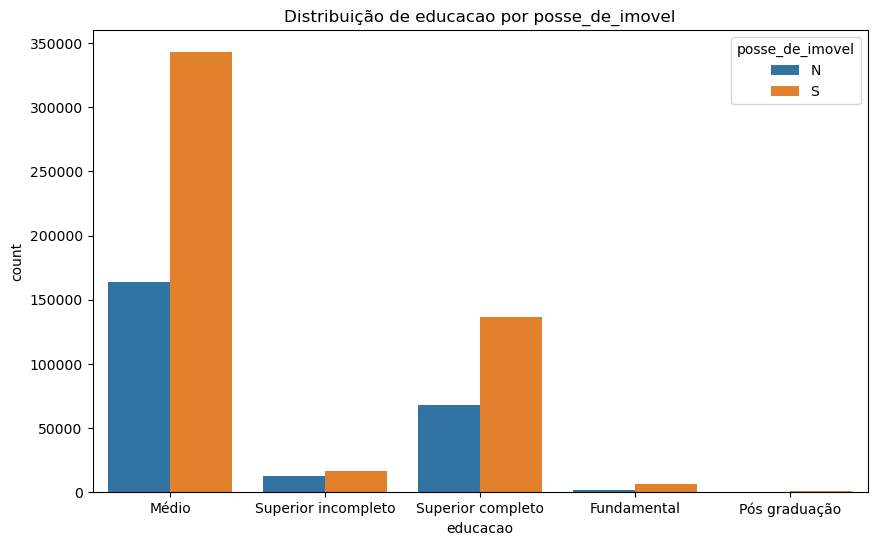

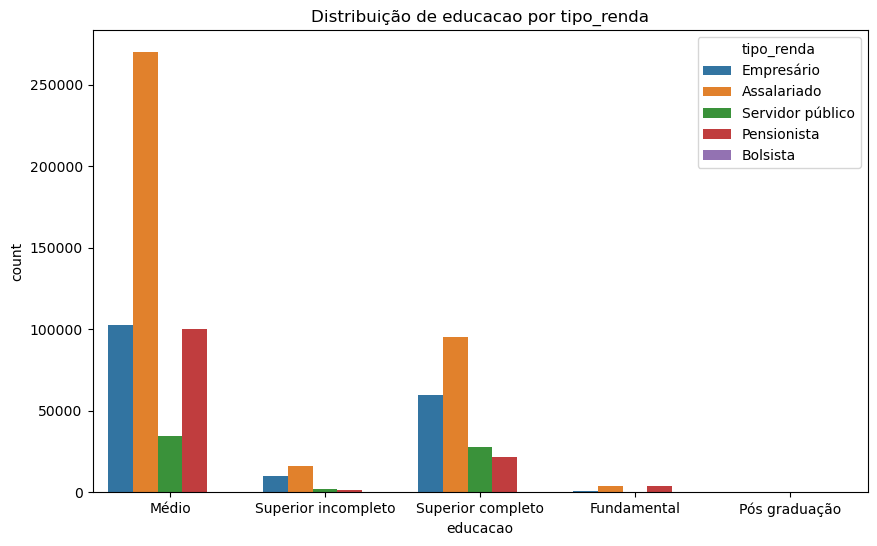

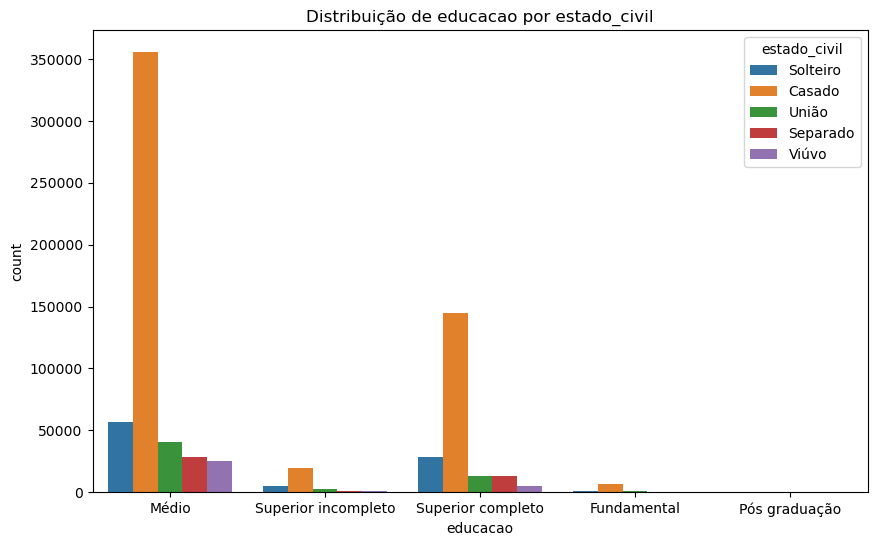

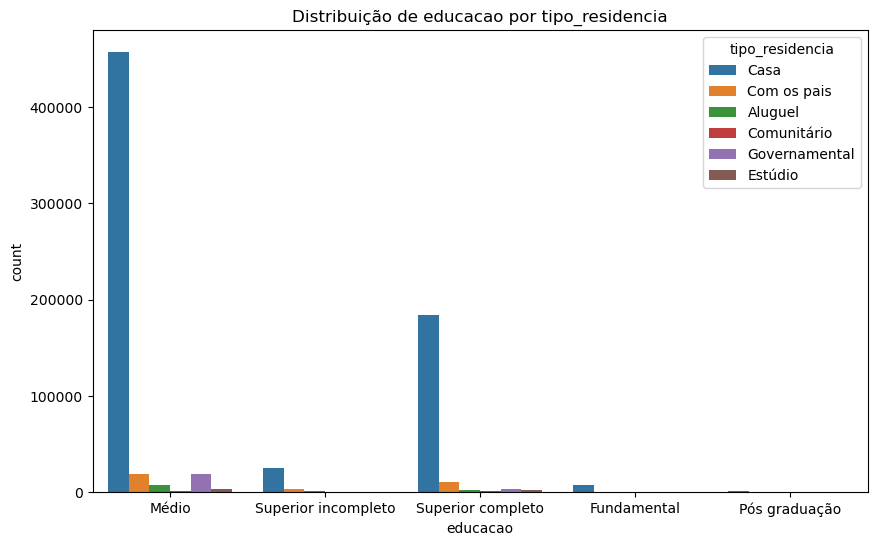

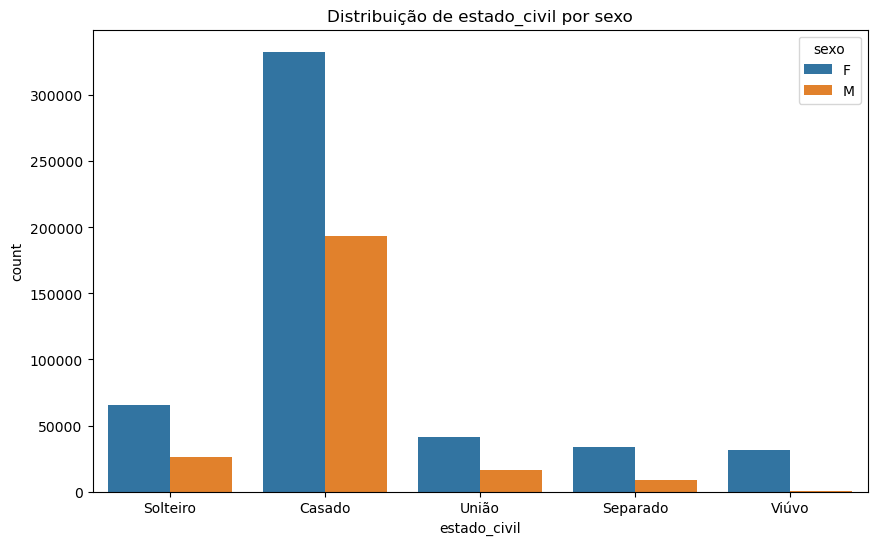

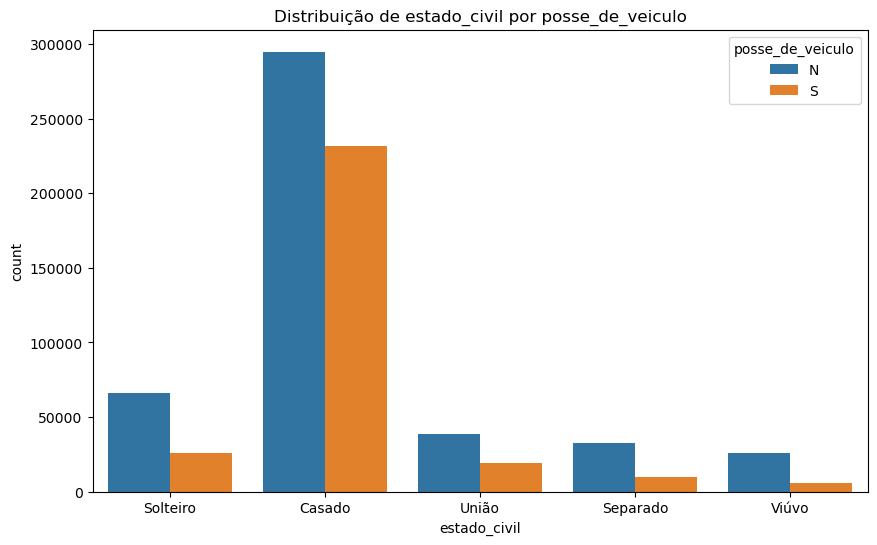

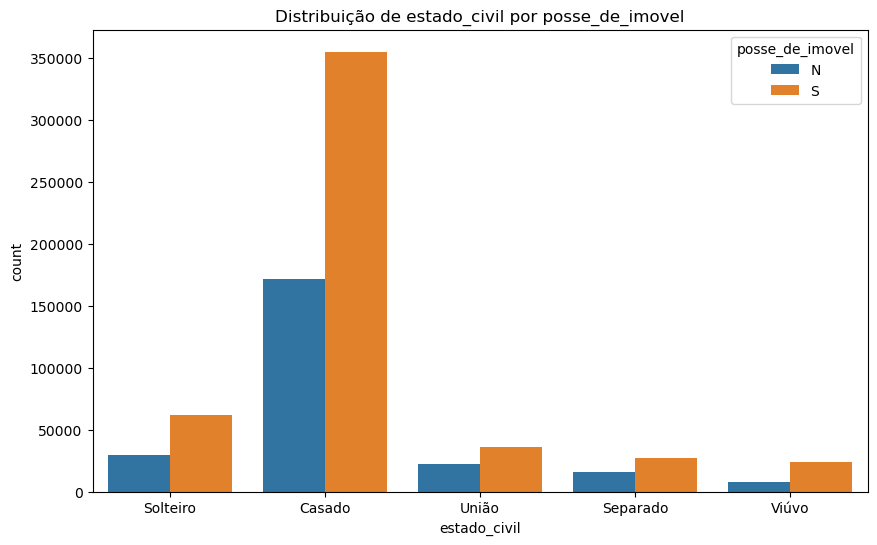

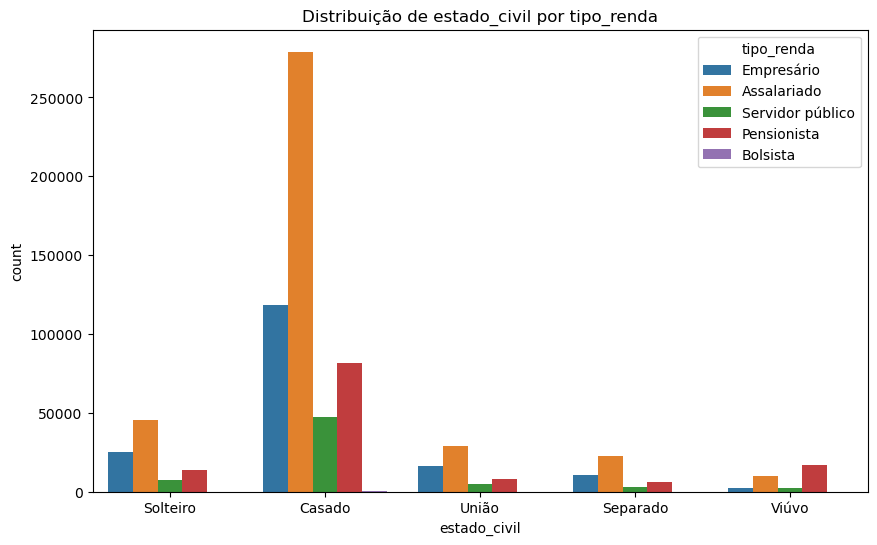

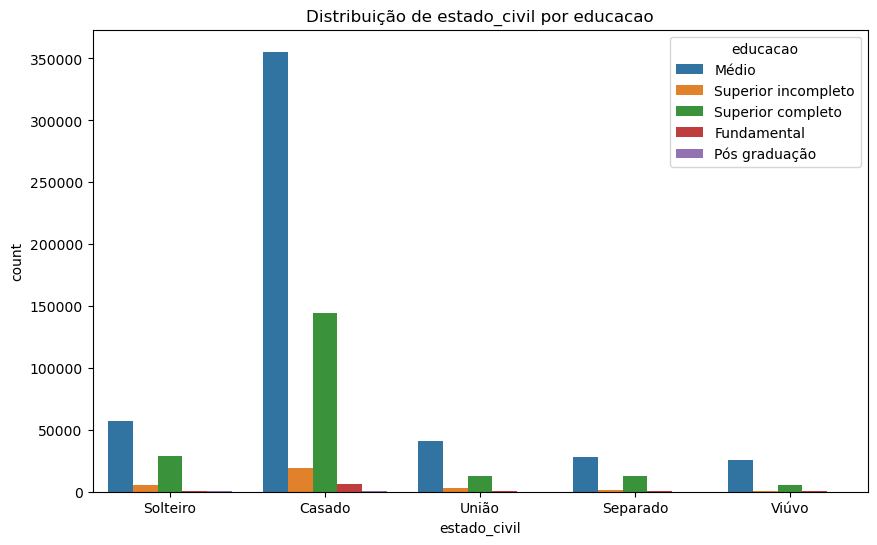

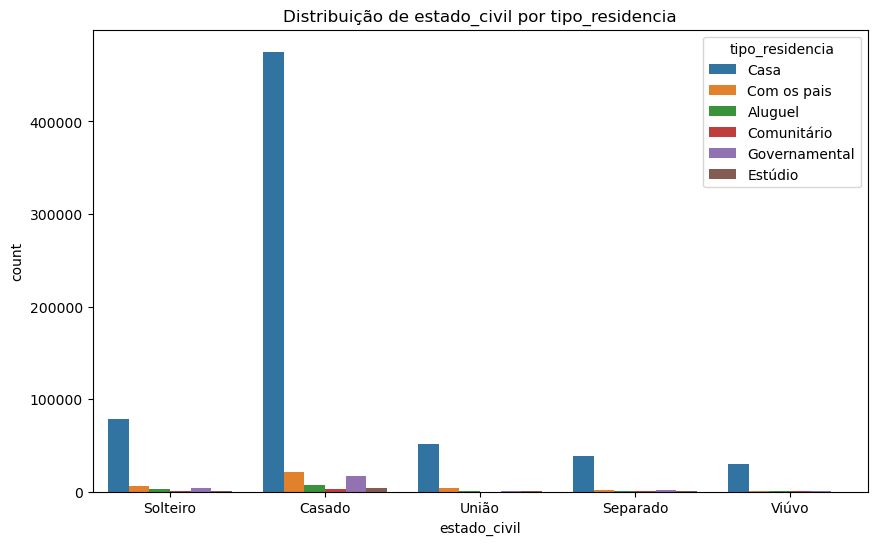

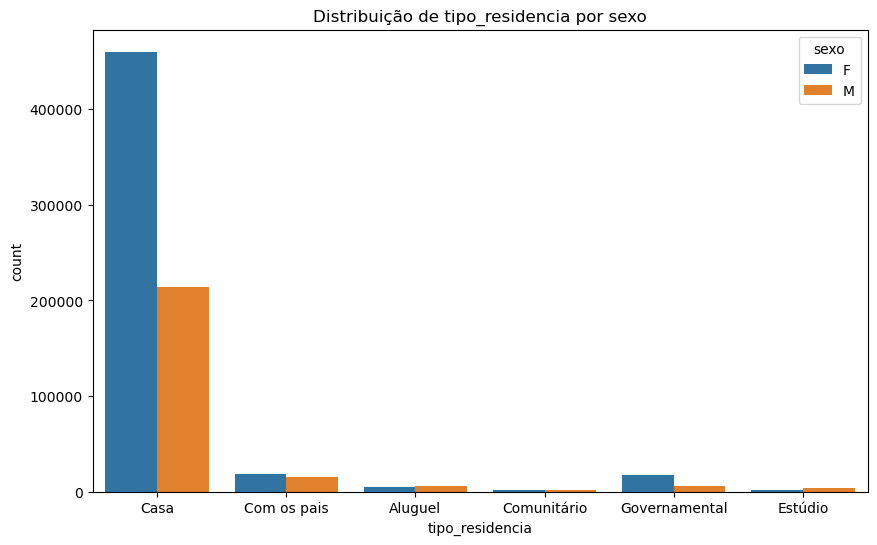

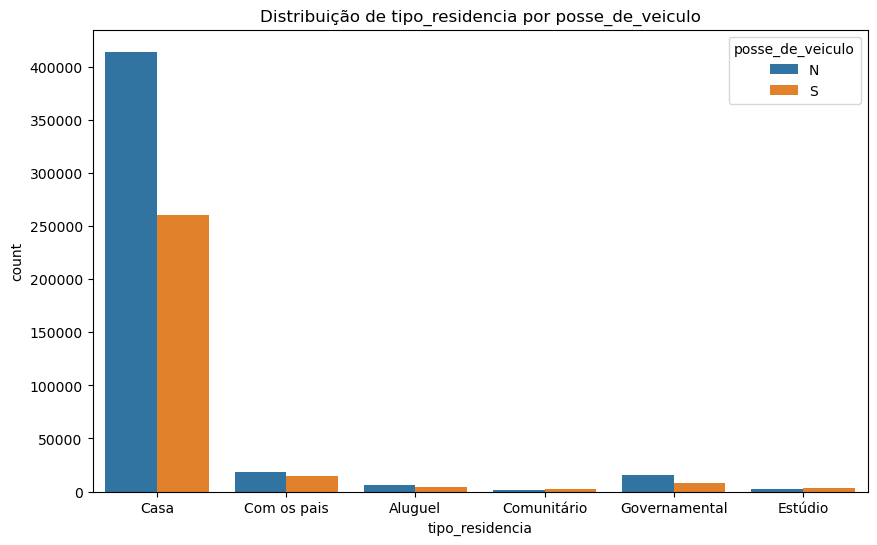

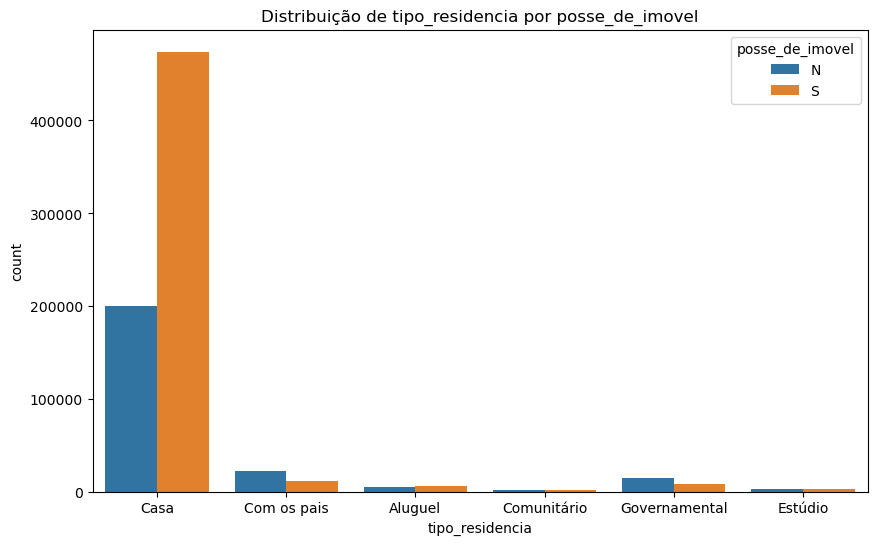

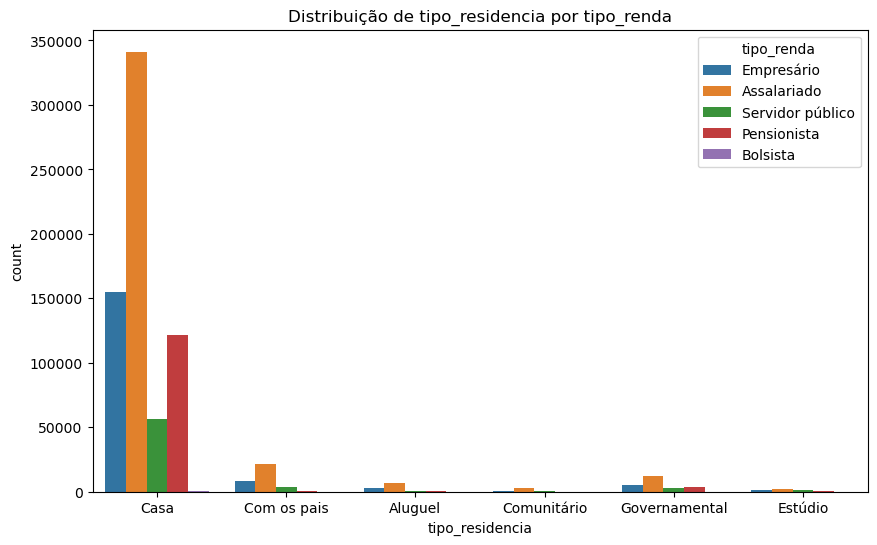

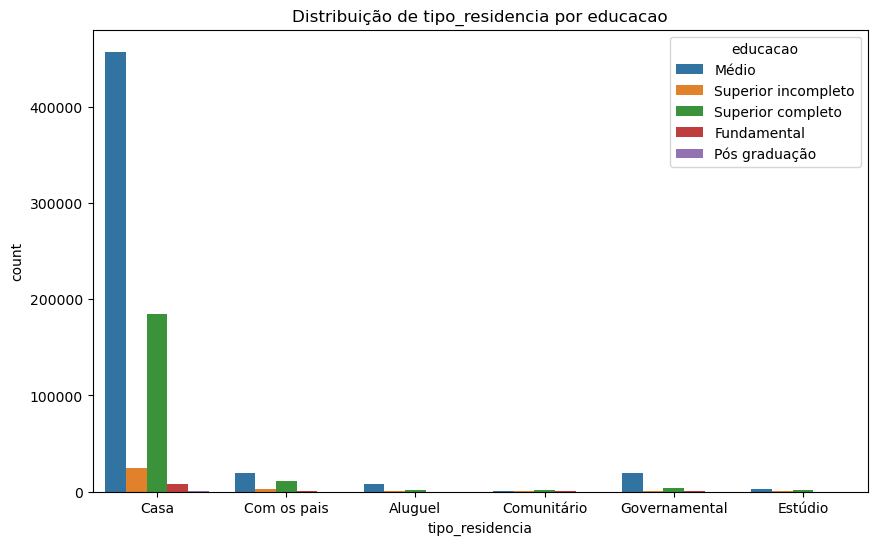

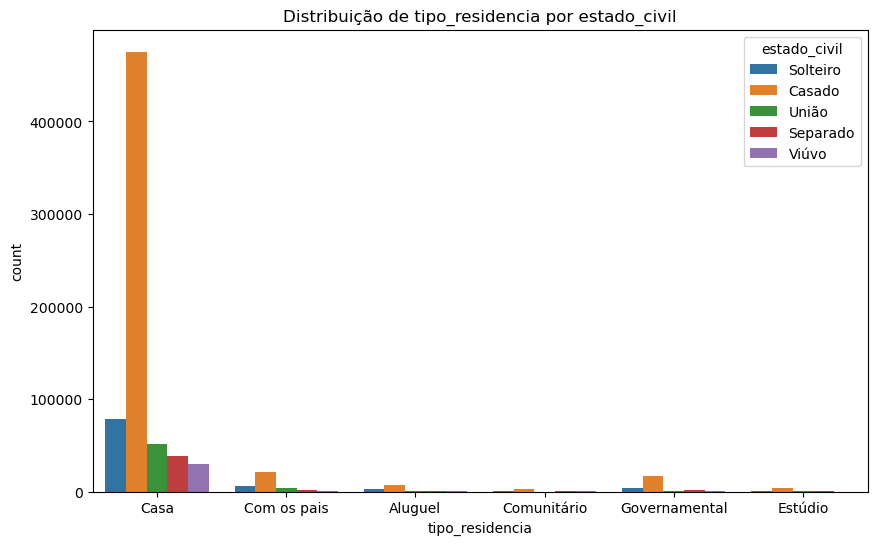

In [5]:
# Análise Bivariada entre Variáveis Qualitativas

# Exemplo de tabela de contingência
qual_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

for var1 in qual_vars:
    for var2 in qual_vars:
        if var1 != var2:
            print(f"\nTabela de contingência entre {var1} e {var2}:")
            print(pd.crosstab(df[var1], df[var2]))
            print("\n")

# Gráficos de barras empilhadas
for var1 in qual_vars:
    for var2 in qual_vars:
        if var1 != var2:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=var1, hue=var2)
            plt.title(f"Distribuição de {var1} por {var2}")
            plt.show()


Matriz de Correlação:
                       qtd_filhos     idade  tempo_emprego  \
qtd_filhos               1.000000 -0.370234      -0.075299   
idade                   -0.370234  1.000000       0.330063   
tempo_emprego           -0.075299  0.330063       1.000000   
qt_pessoas_residencia    0.890352 -0.341151      -0.066361   
renda                   -0.041886  0.101772       0.496360   

                       qt_pessoas_residencia     renda  
qtd_filhos                          0.890352 -0.041886  
idade                              -0.341151  0.101772  
tempo_emprego                      -0.066361  0.496360  
qt_pessoas_residencia               1.000000 -0.047790  
renda                              -0.047790  1.000000  


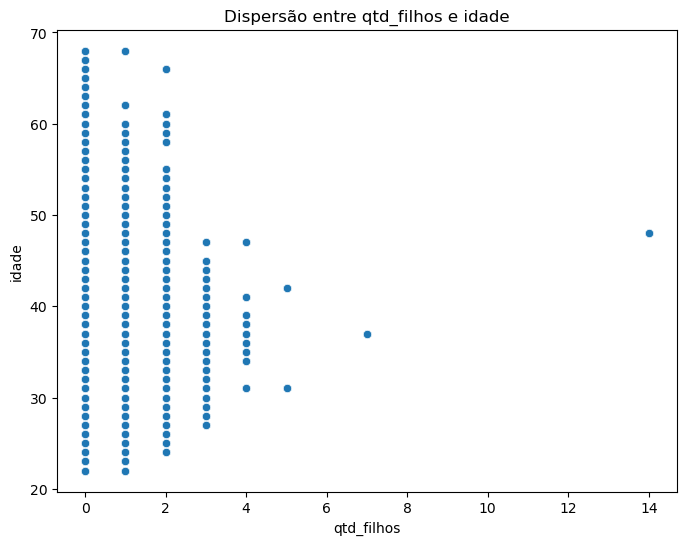

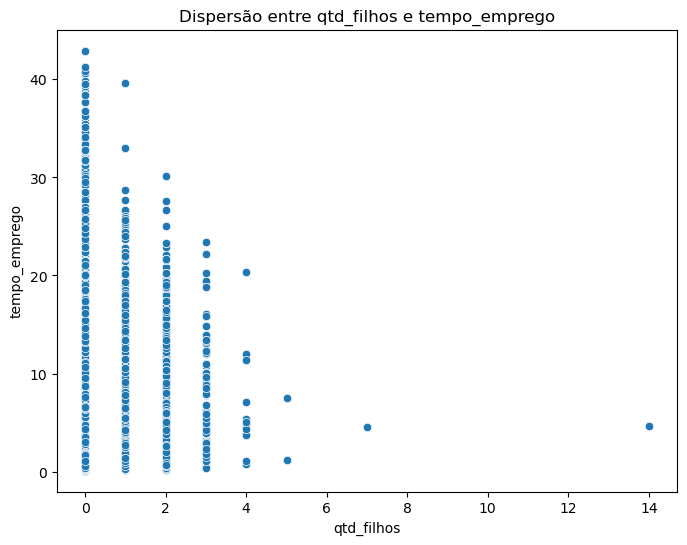

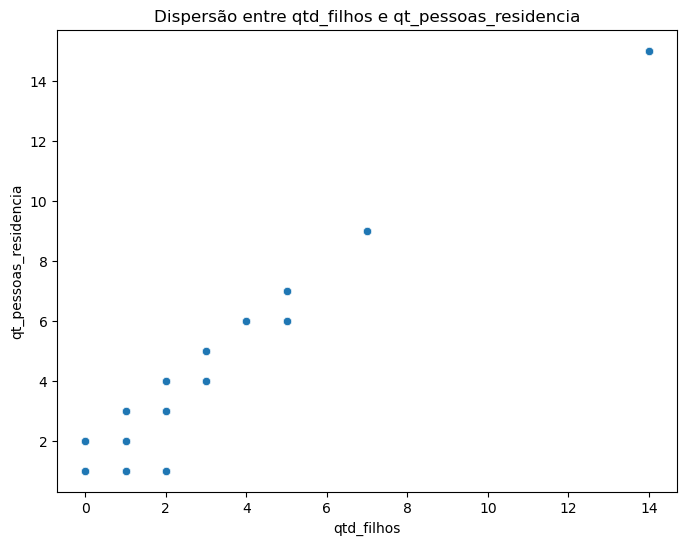

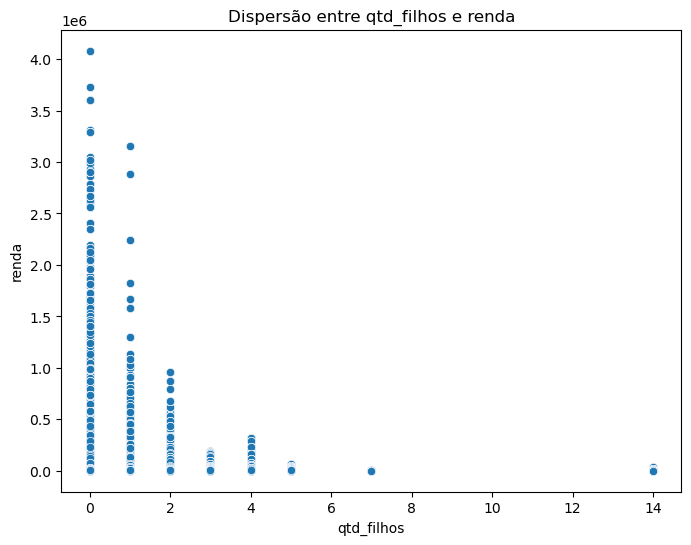

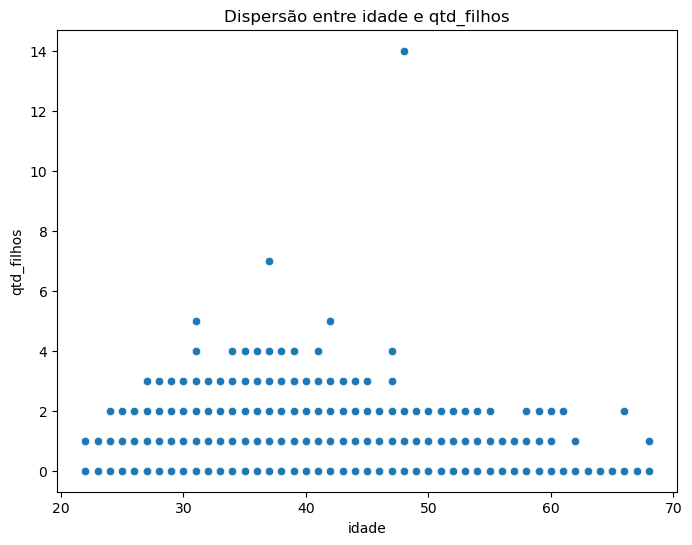

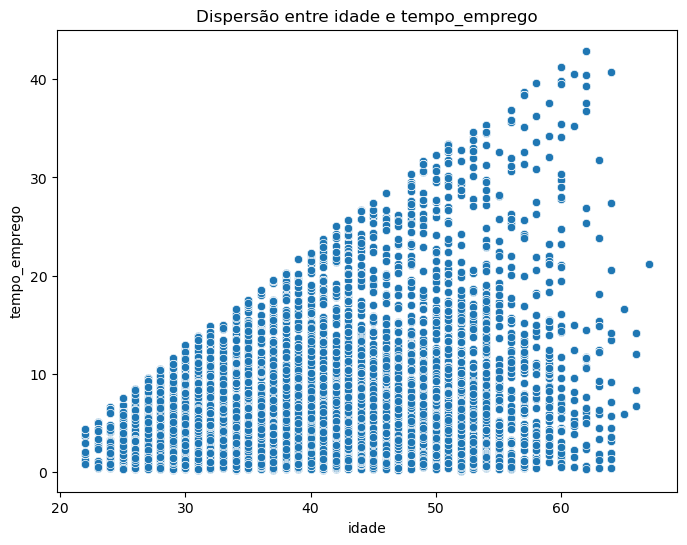

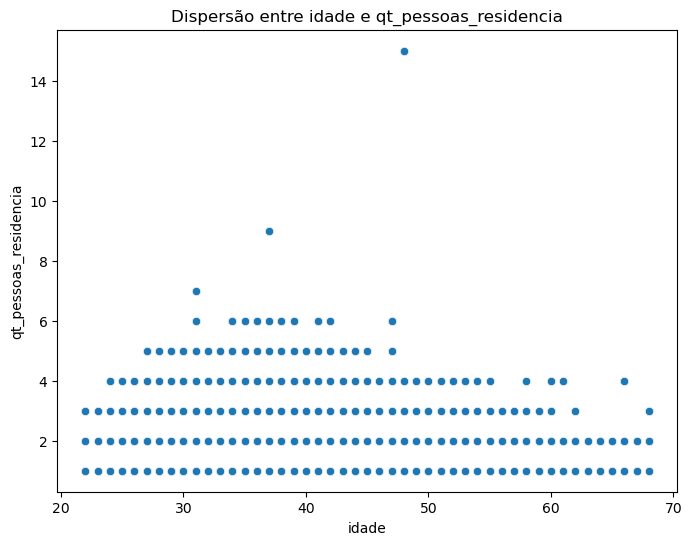

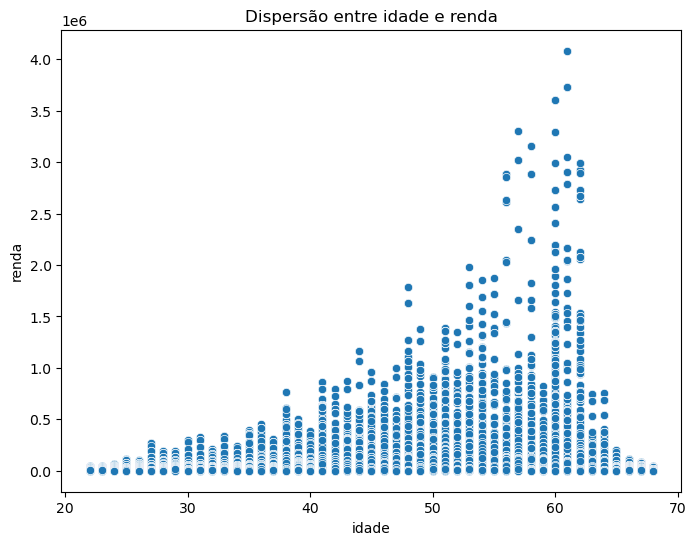

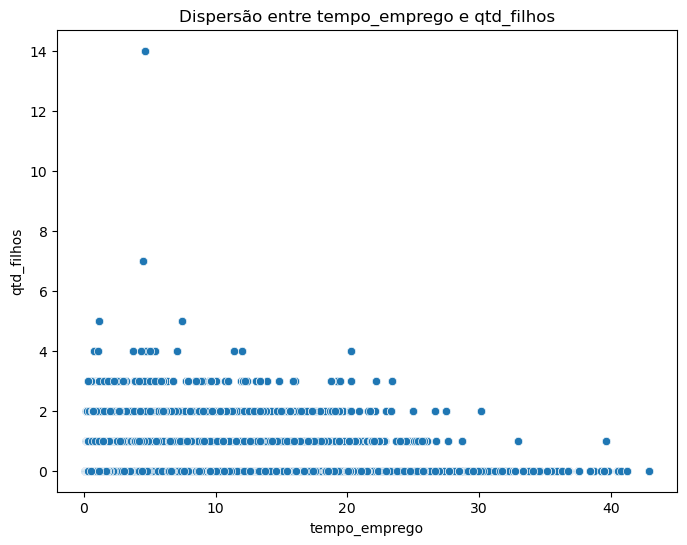

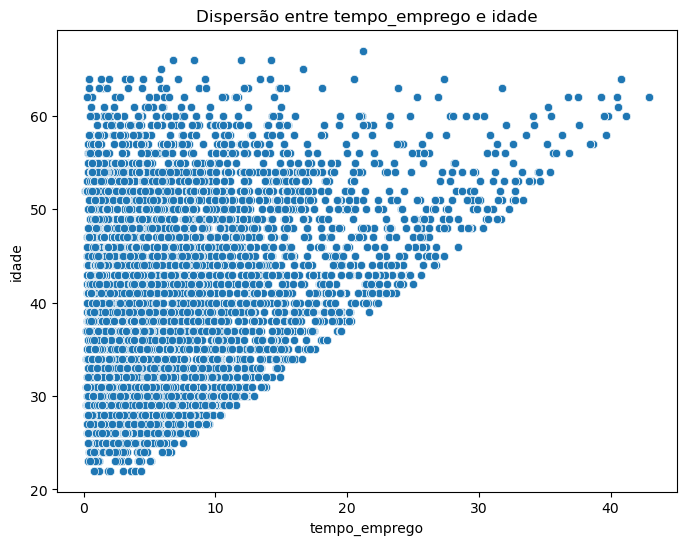

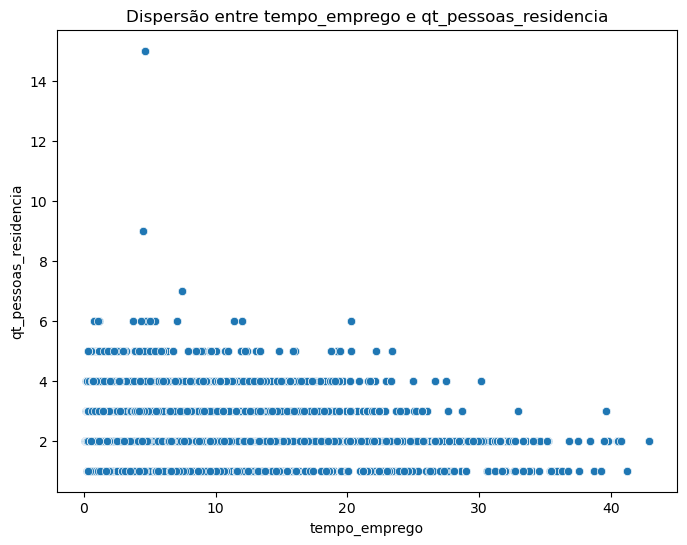

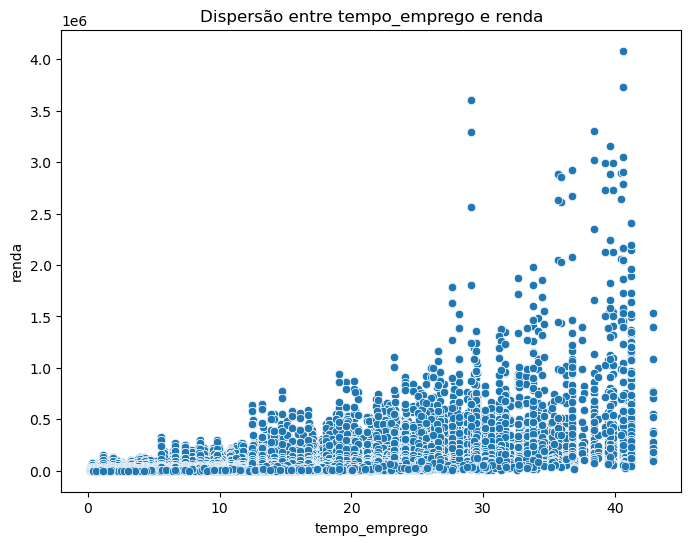

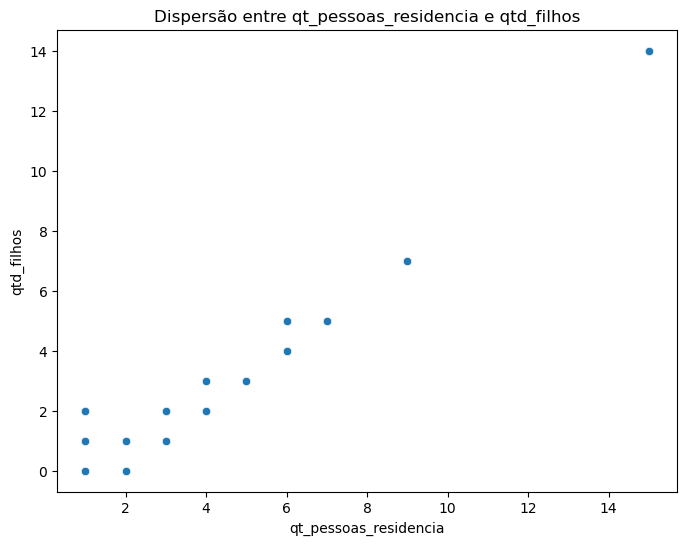

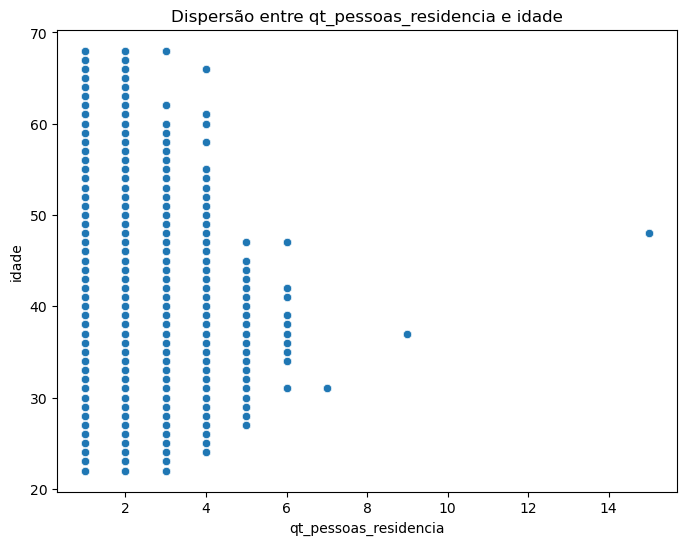

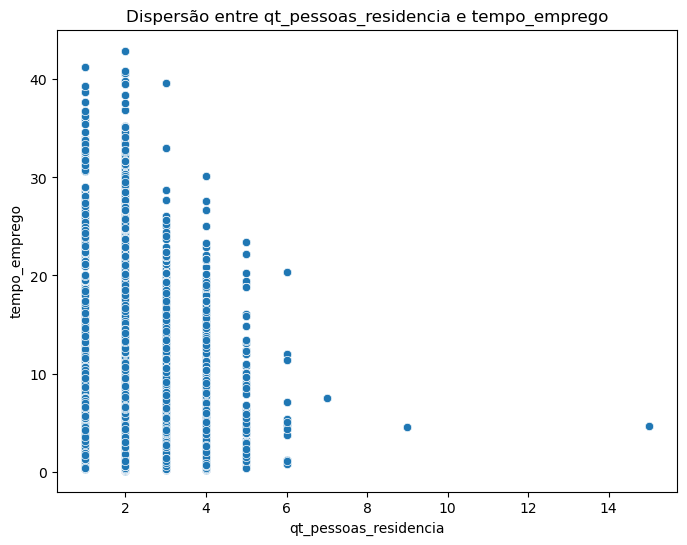

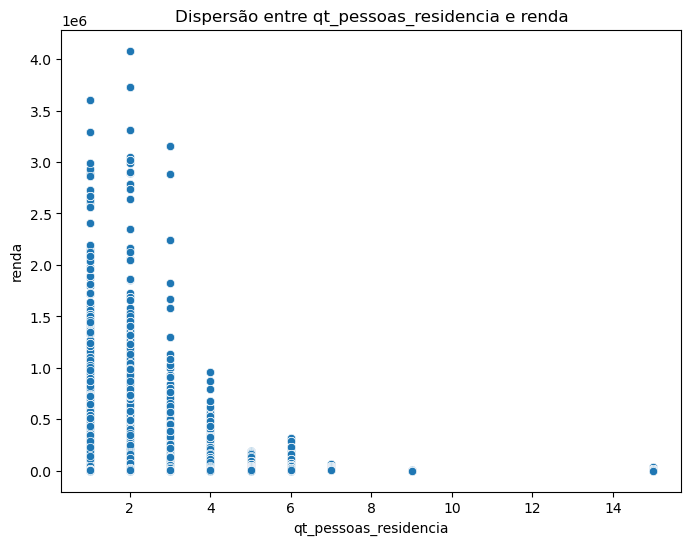

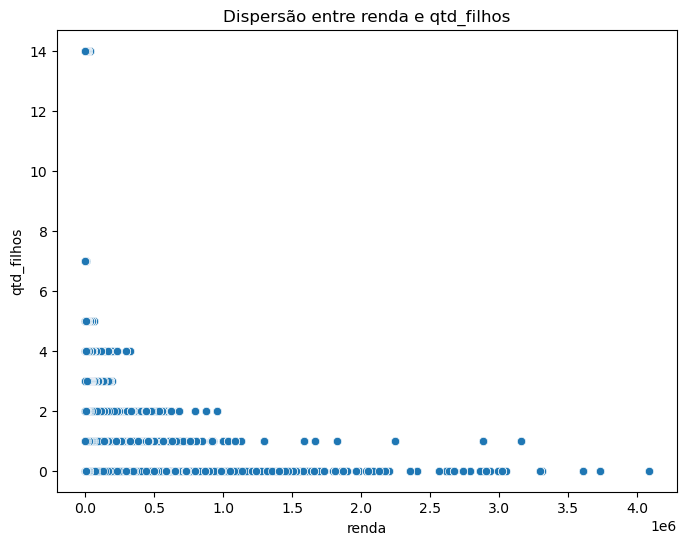

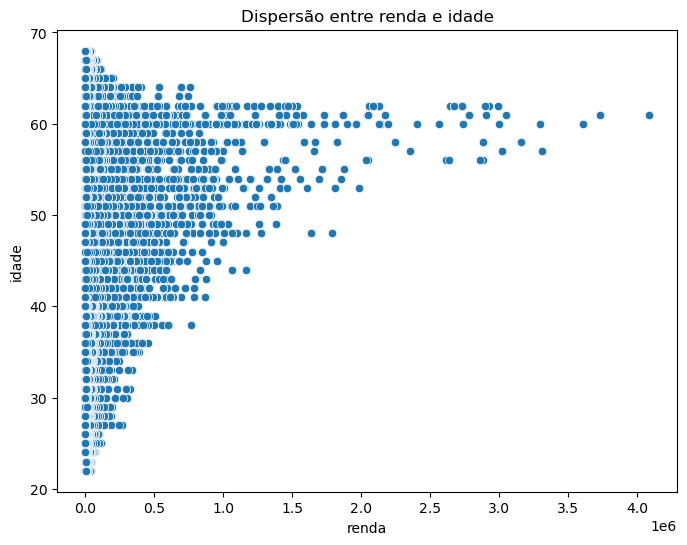

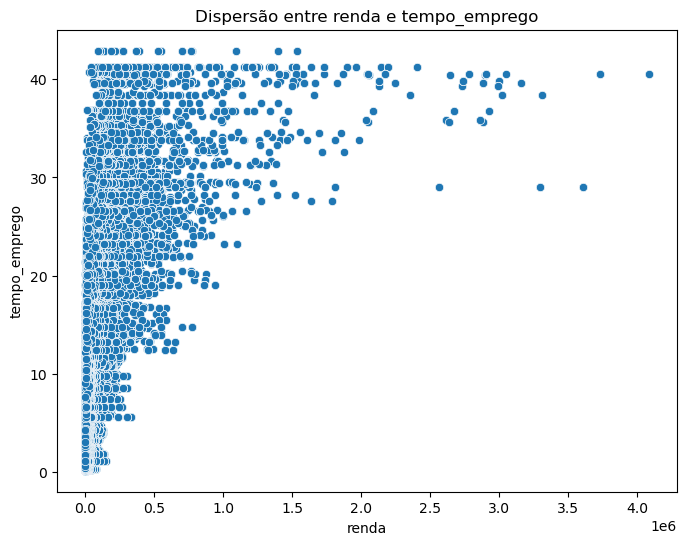

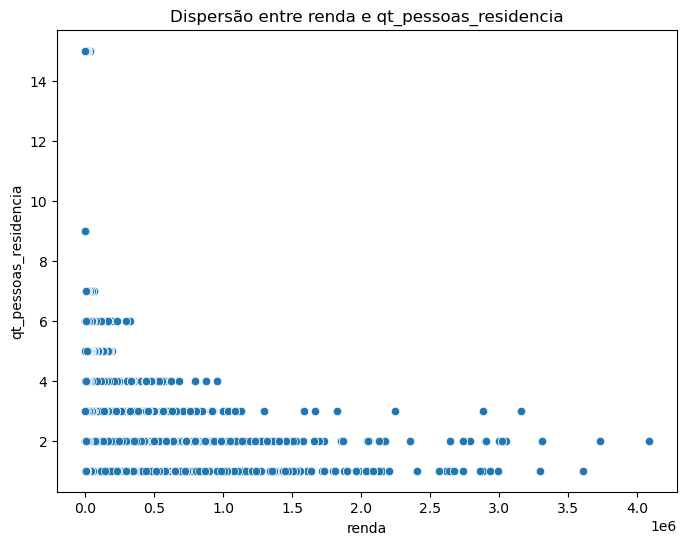

In [6]:
# Análise Bivariada entre Variáveis Quantitativas

quant_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Correlação
correlation_matrix = df[quant_vars].corr()
print("\nMatriz de Correlação:")
print(correlation_matrix)

# Gráficos de dispersão
for var1 in quant_vars:
    for var2 in quant_vars:
        if var1 != var2:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=var1, y=var2)
            plt.title(f"Dispersão entre {var1} e {var2}")
            plt.xlabel(var1)
            plt.ylabel(var2)
            plt.show()

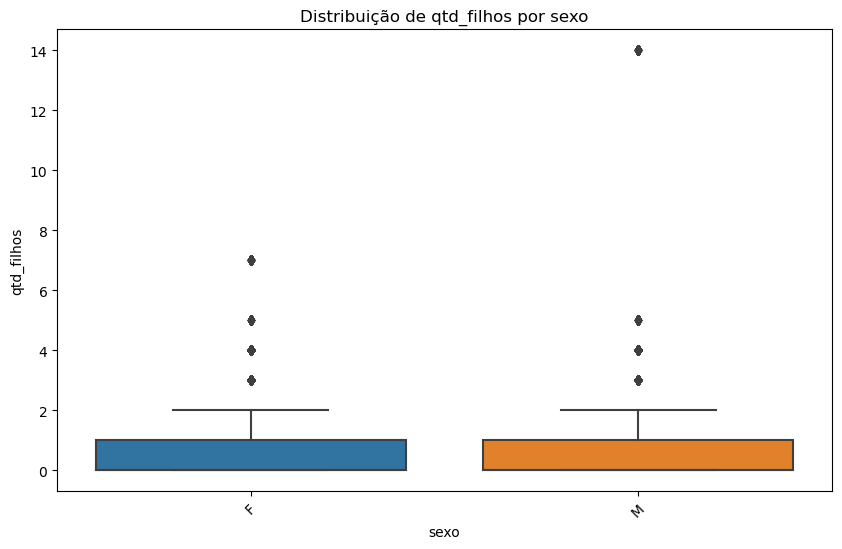

ANOVA entre sexo e qtd_filhos: F=10186.2768, p=0.0000


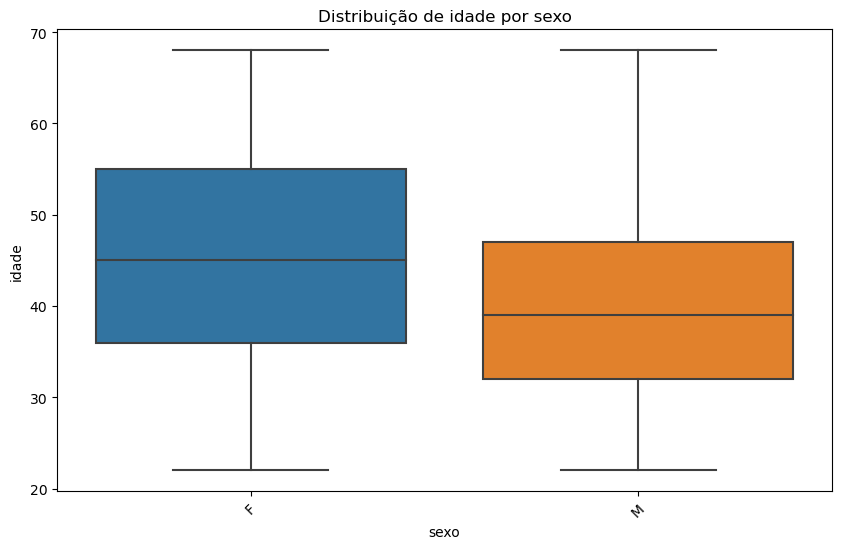

ANOVA entre sexo e idade: F=36816.3474, p=0.0000


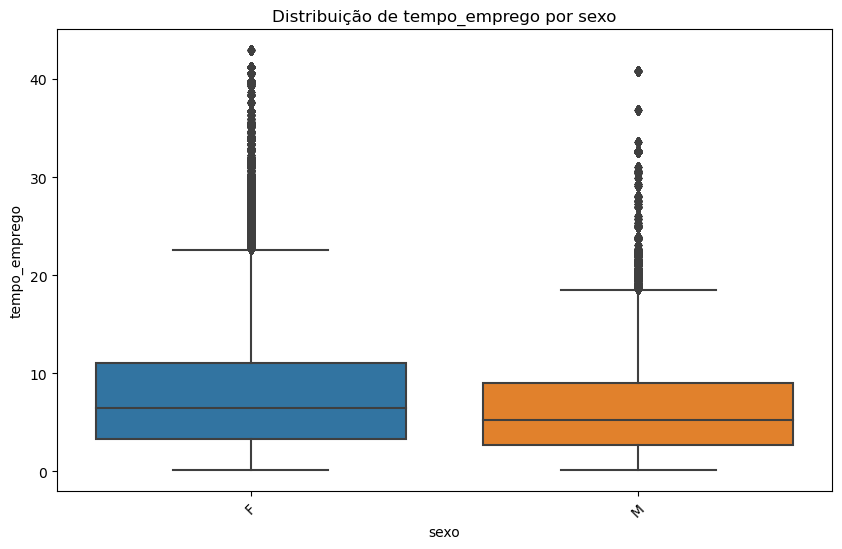

ANOVA entre sexo e tempo_emprego: F=nan, p=nan


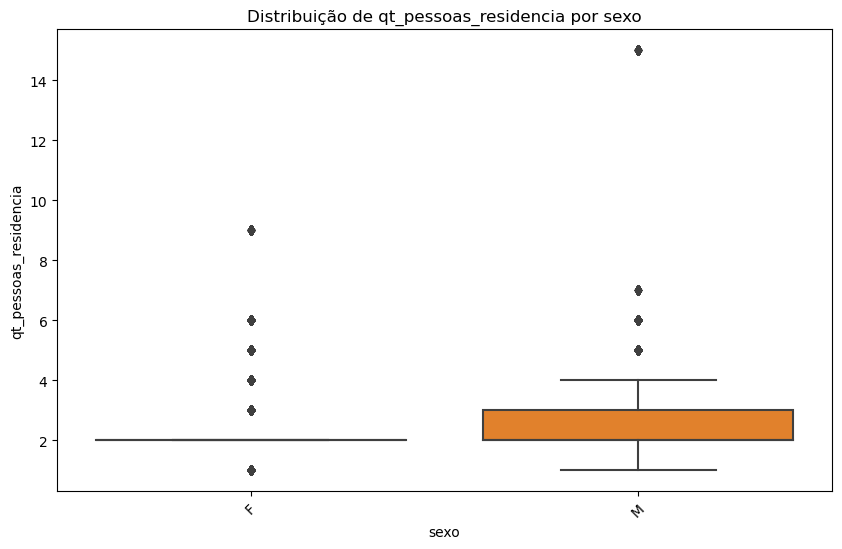

ANOVA entre sexo e qt_pessoas_residencia: F=18119.7372, p=0.0000


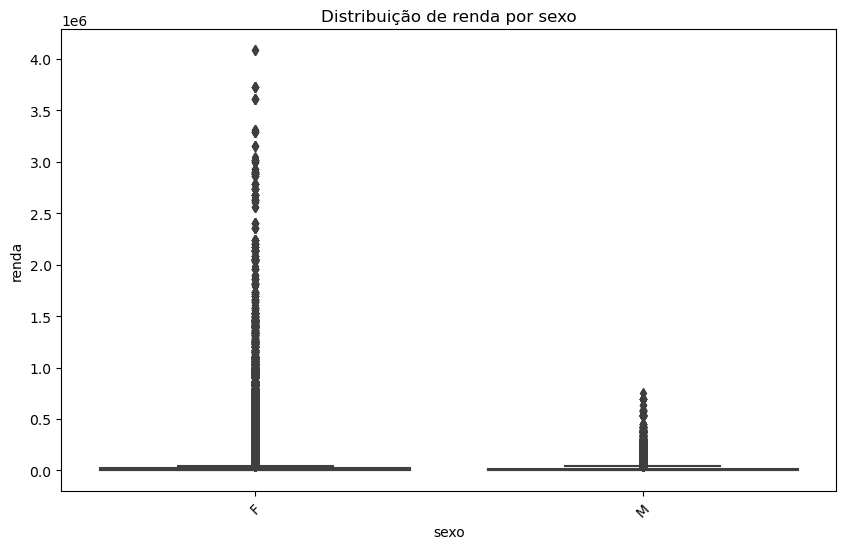

ANOVA entre sexo e renda: F=3792.6704, p=0.0000


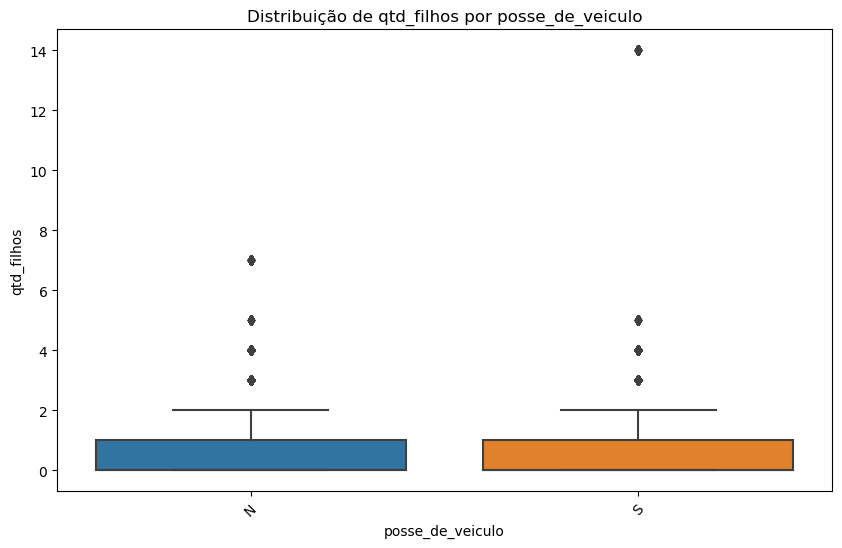

ANOVA entre posse_de_veiculo e qtd_filhos: F=9874.9967, p=0.0000


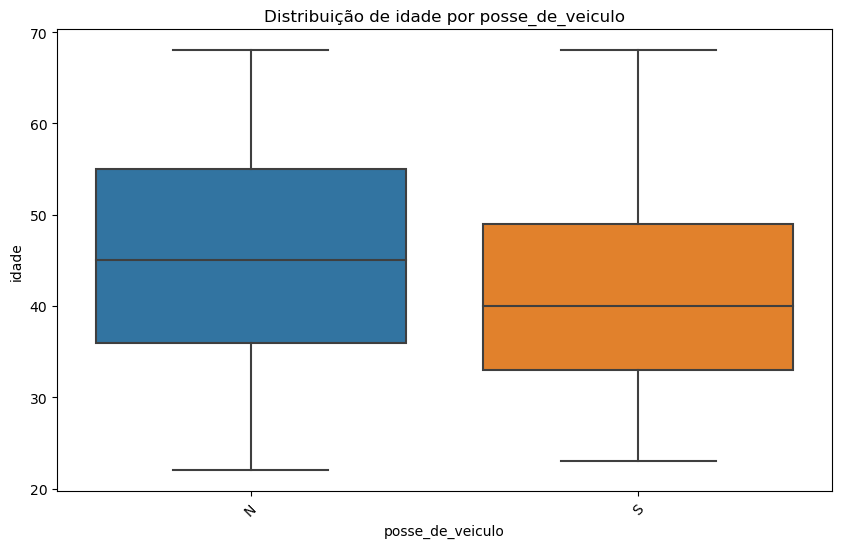

ANOVA entre posse_de_veiculo e idade: F=22255.4708, p=0.0000


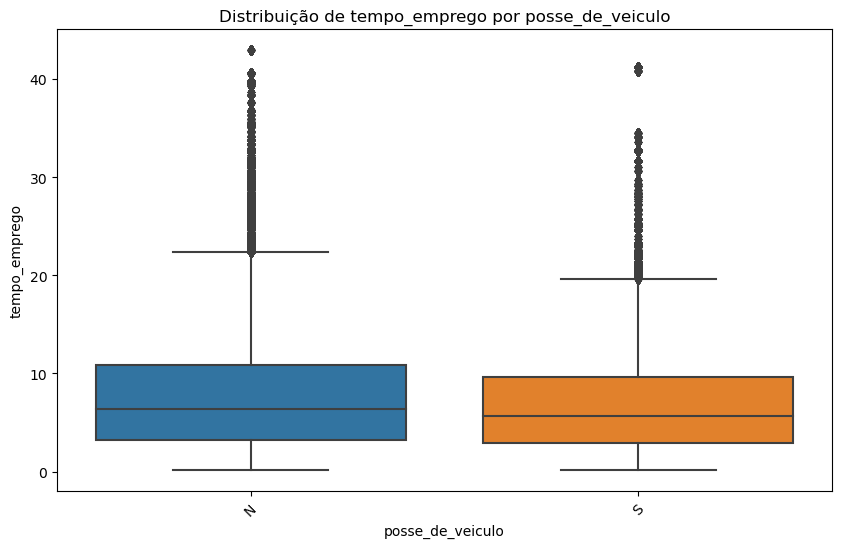

ANOVA entre posse_de_veiculo e tempo_emprego: F=nan, p=nan


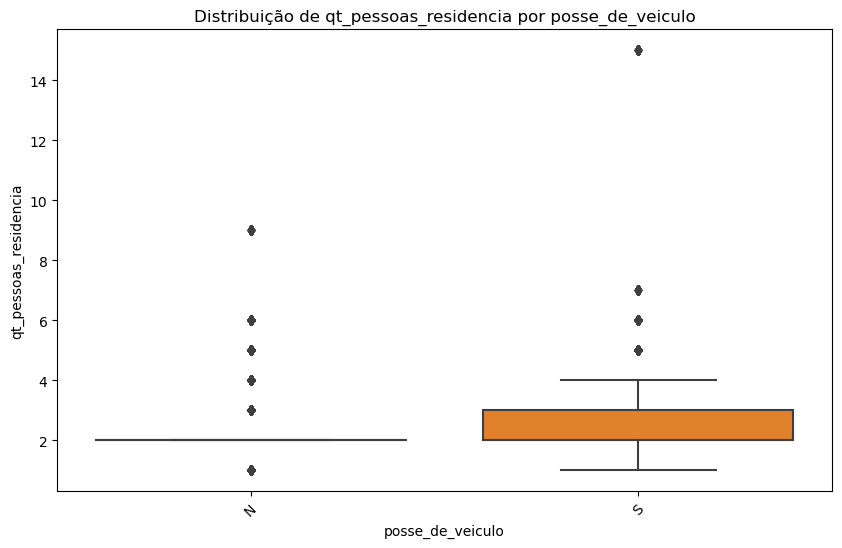

ANOVA entre posse_de_veiculo e qt_pessoas_residencia: F=20504.0334, p=0.0000


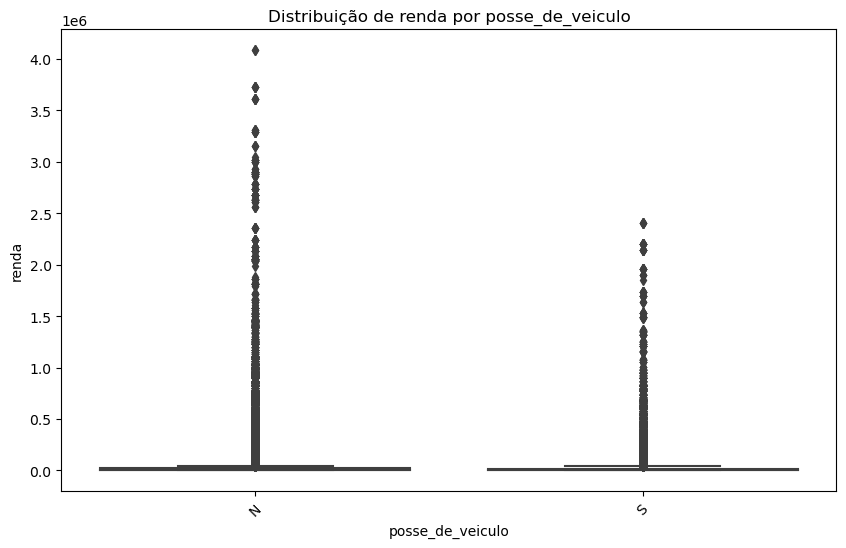

ANOVA entre posse_de_veiculo e renda: F=901.4262, p=0.0000


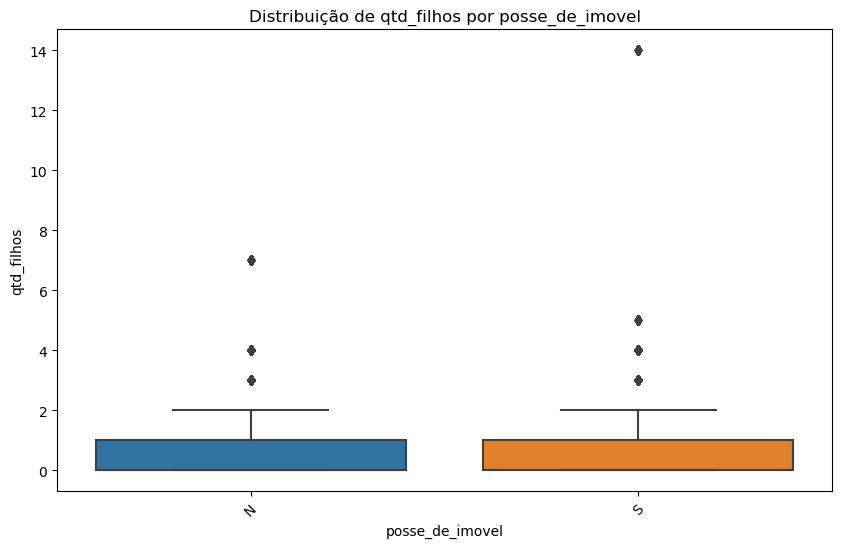

ANOVA entre posse_de_imovel e qtd_filhos: F=117.8212, p=0.0000


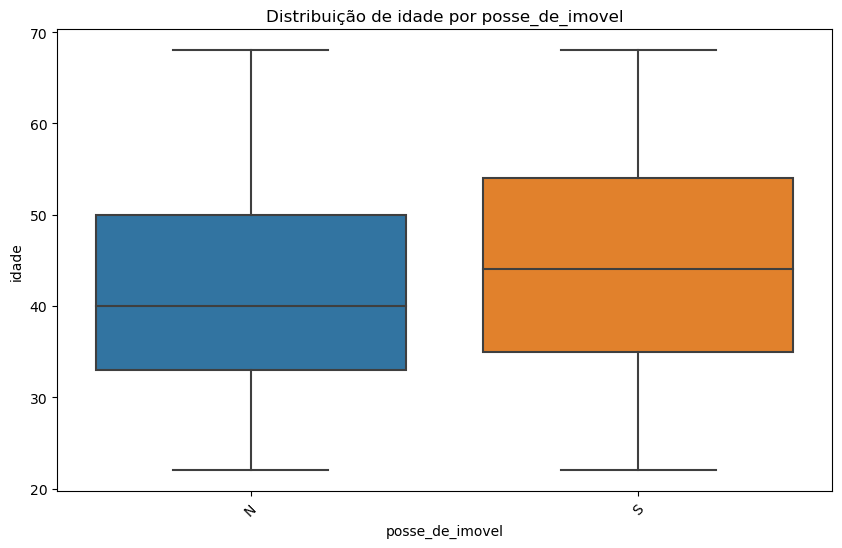

ANOVA entre posse_de_imovel e idade: F=13277.9096, p=0.0000


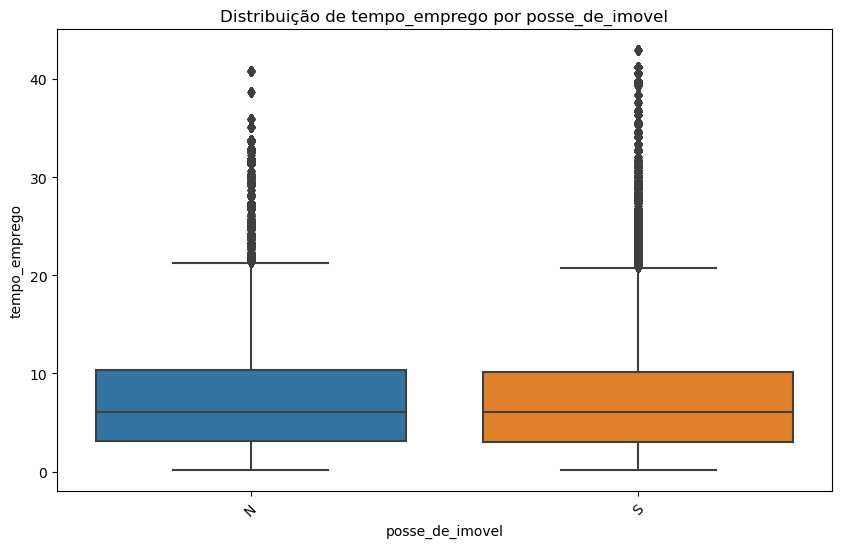

ANOVA entre posse_de_imovel e tempo_emprego: F=nan, p=nan


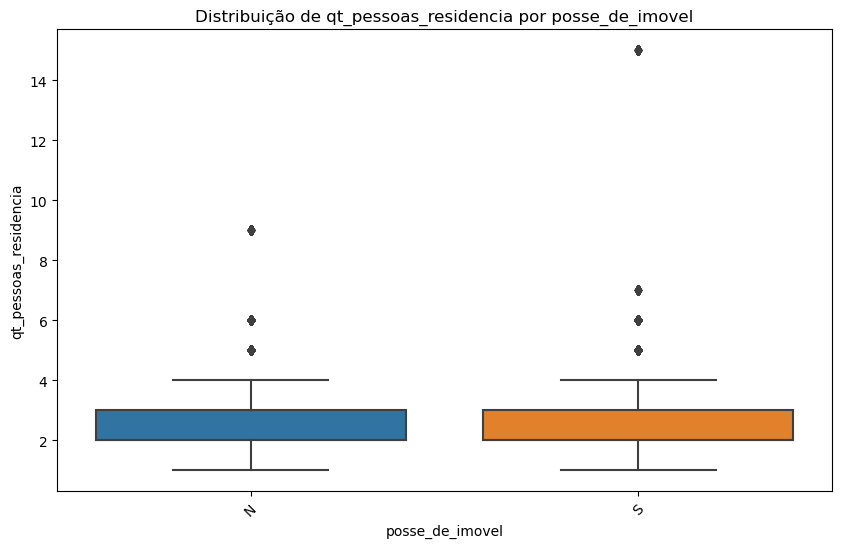

ANOVA entre posse_de_imovel e qt_pessoas_residencia: F=194.3105, p=0.0000


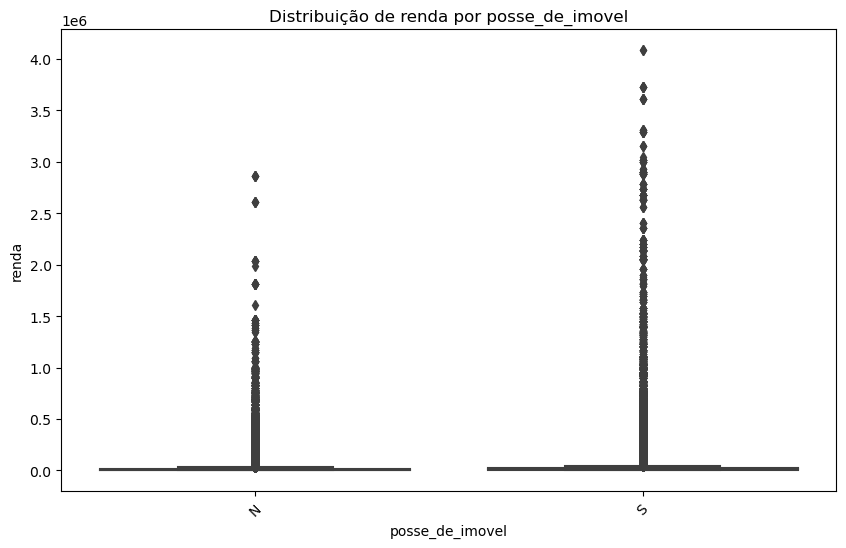

ANOVA entre posse_de_imovel e renda: F=656.8934, p=0.0000


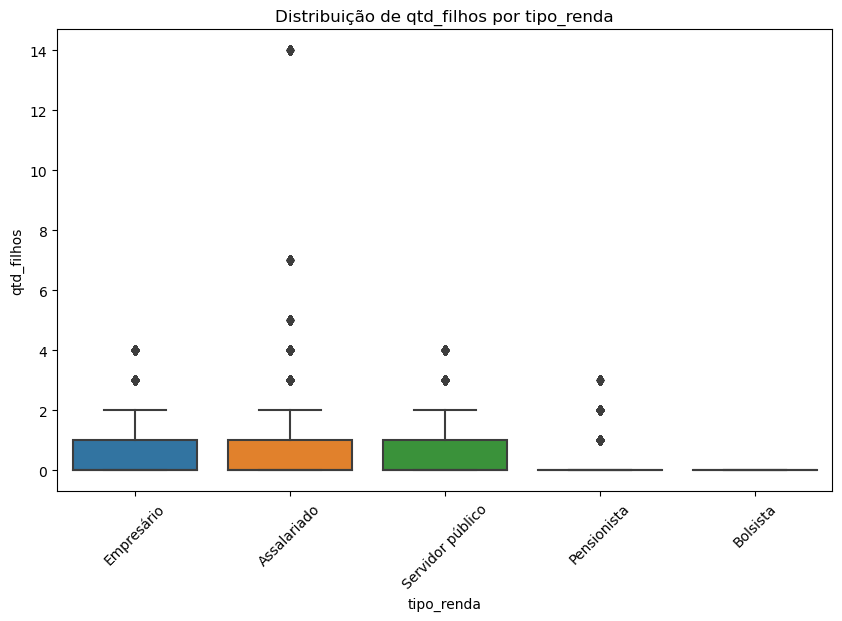

ANOVA entre tipo_renda e qtd_filhos: F=11666.6049, p=0.0000


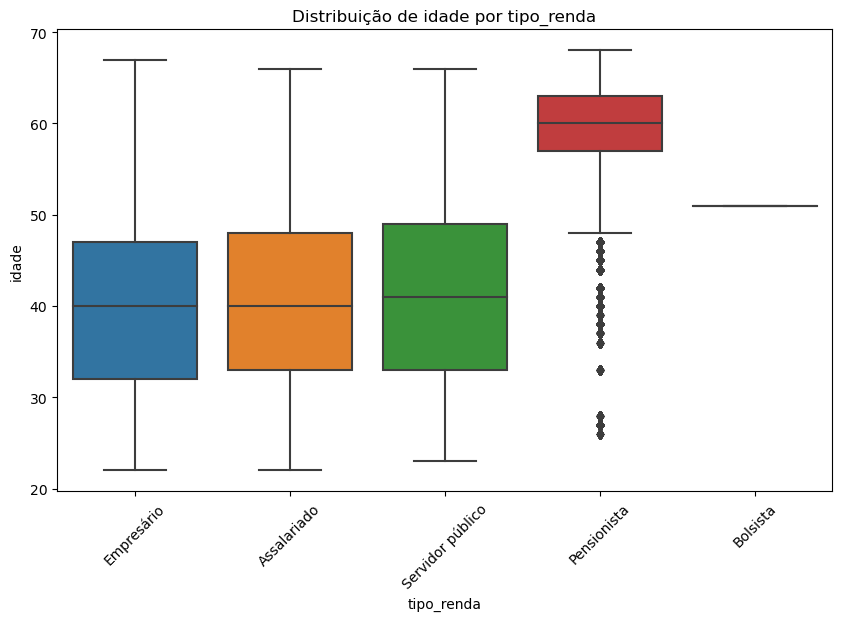

ANOVA entre tipo_renda e idade: F=117692.2502, p=0.0000


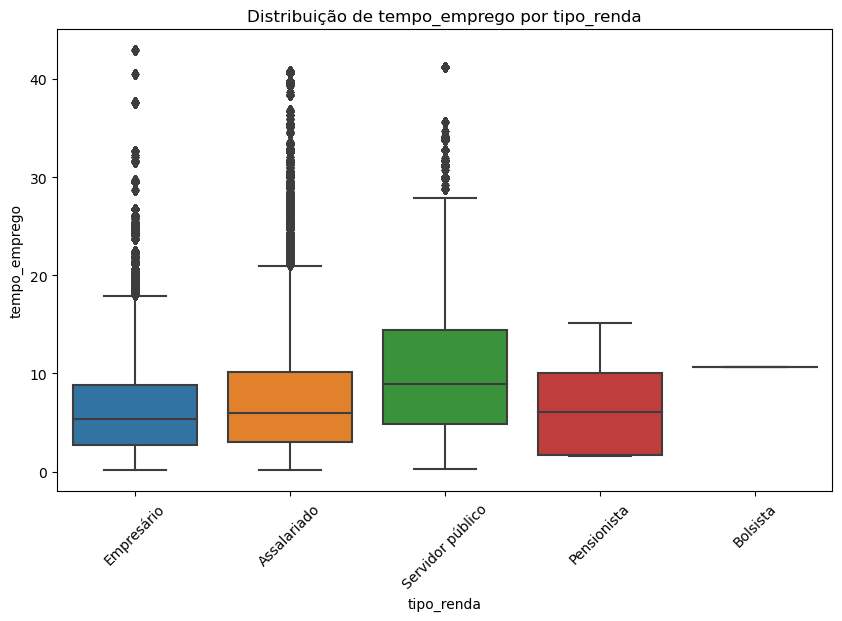

ANOVA entre tipo_renda e tempo_emprego: F=nan, p=nan


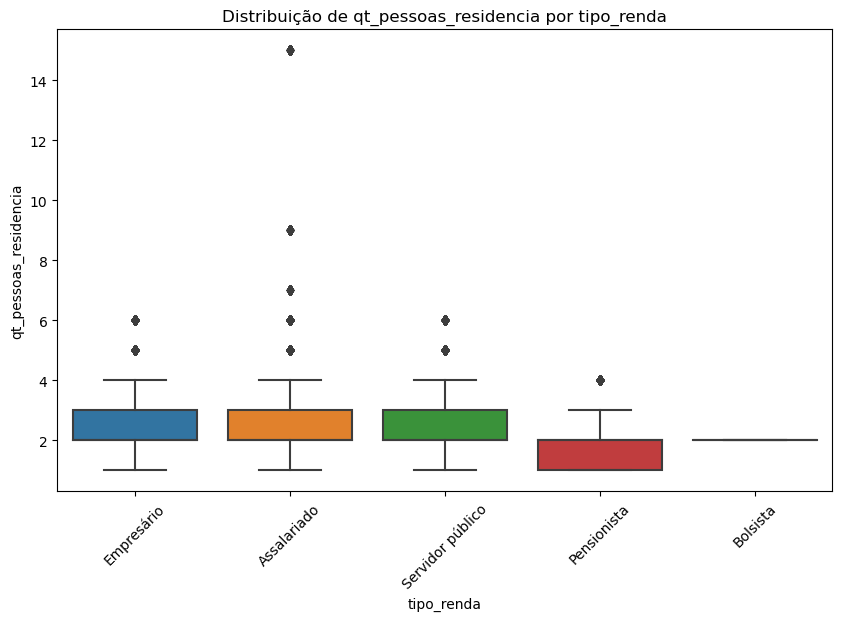

ANOVA entre tipo_renda e qt_pessoas_residencia: F=10912.3641, p=0.0000


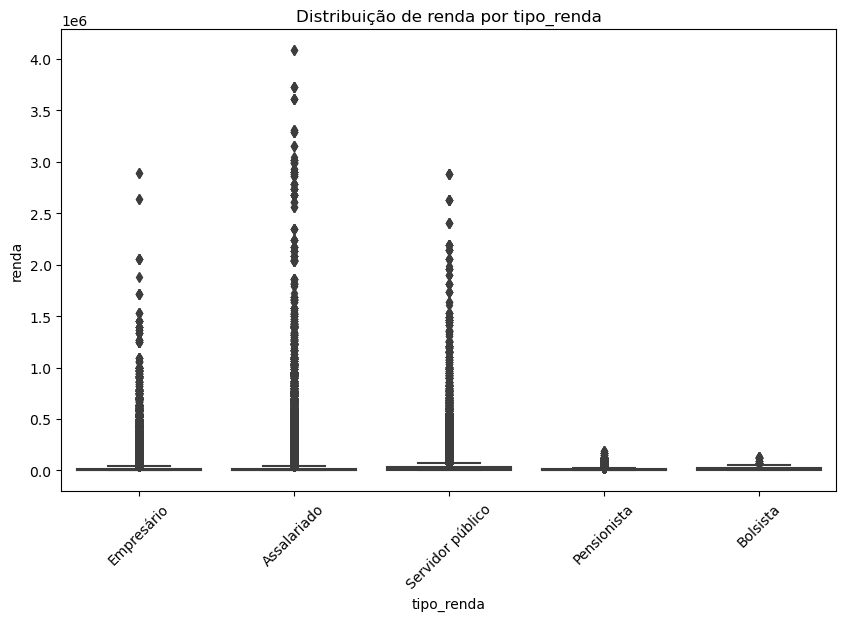

ANOVA entre tipo_renda e renda: F=2049.5291, p=0.0000


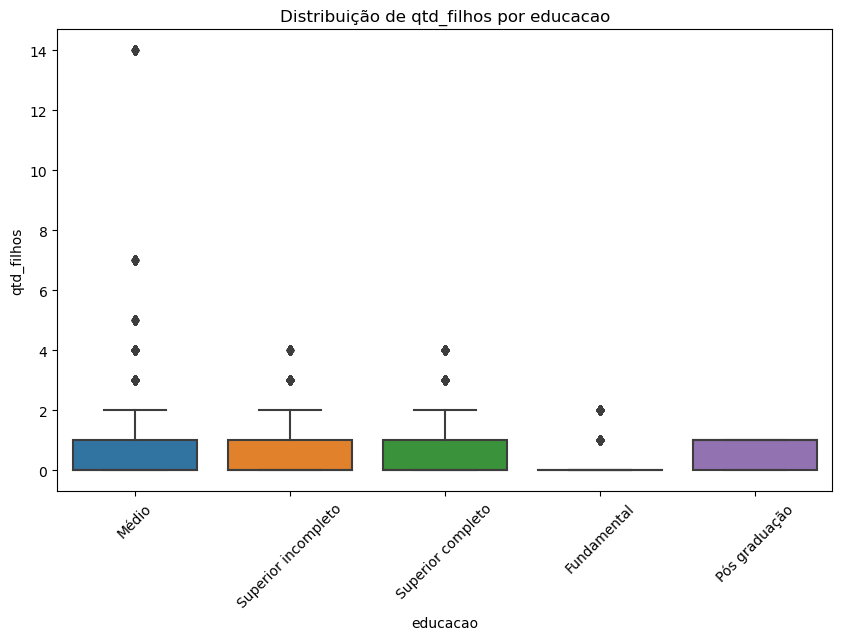

ANOVA entre educacao e qtd_filhos: F=976.3978, p=0.0000


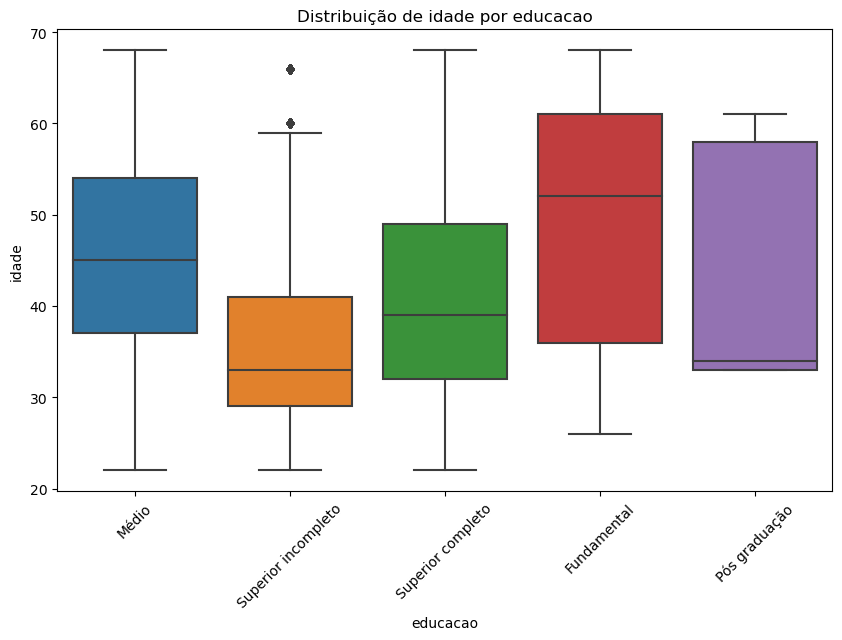

ANOVA entre educacao e idade: F=9838.1904, p=0.0000


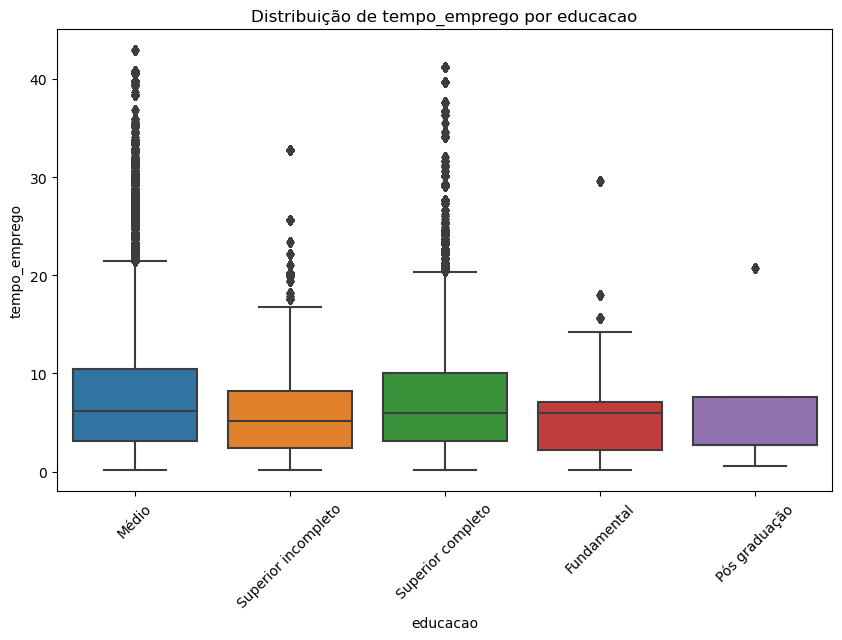

ANOVA entre educacao e tempo_emprego: F=nan, p=nan


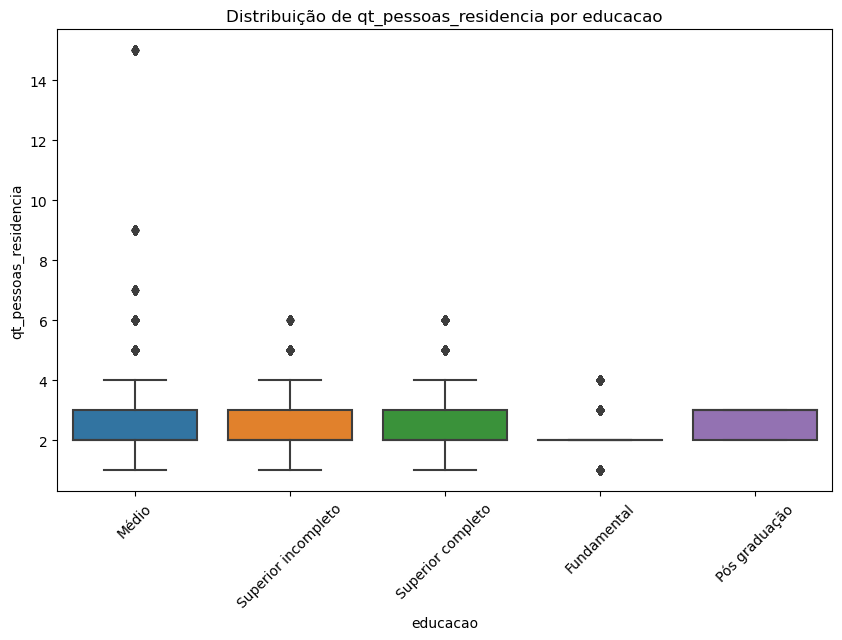

ANOVA entre educacao e qt_pessoas_residencia: F=498.5477, p=0.0000


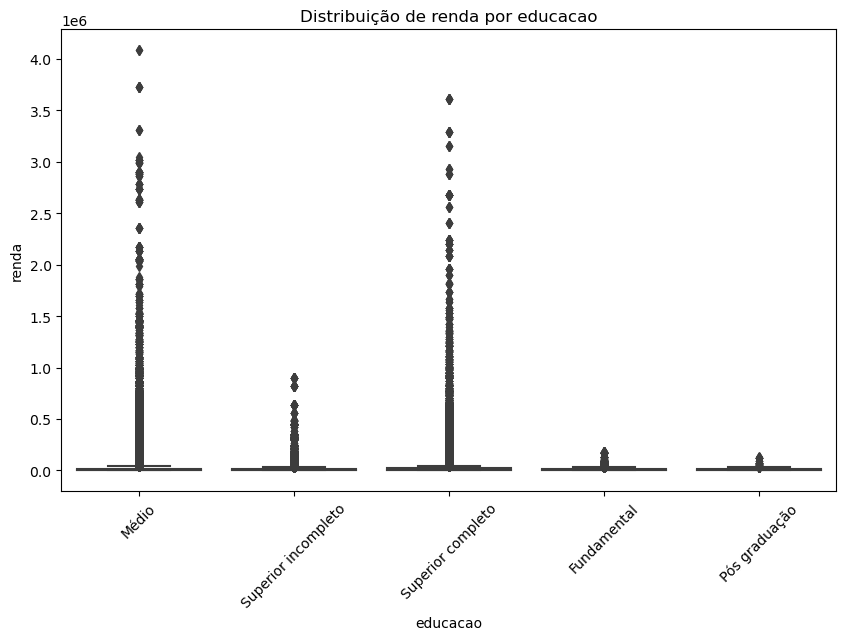

ANOVA entre educacao e renda: F=133.3494, p=0.0000


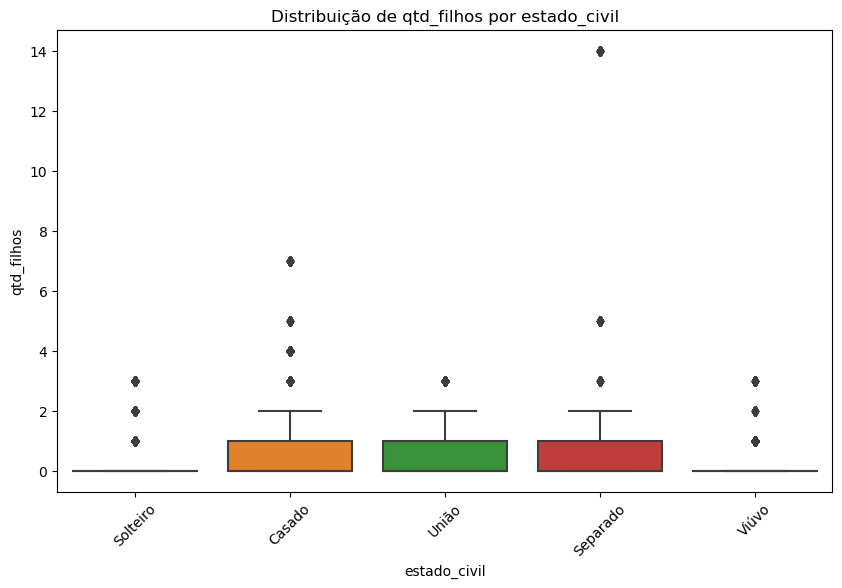

ANOVA entre estado_civil e qtd_filhos: F=5928.5567, p=0.0000


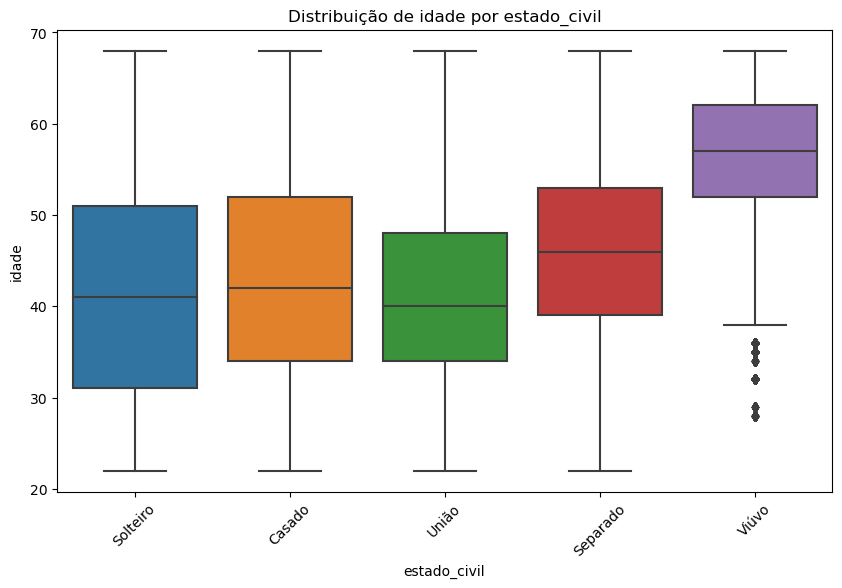

ANOVA entre estado_civil e idade: F=11567.9206, p=0.0000


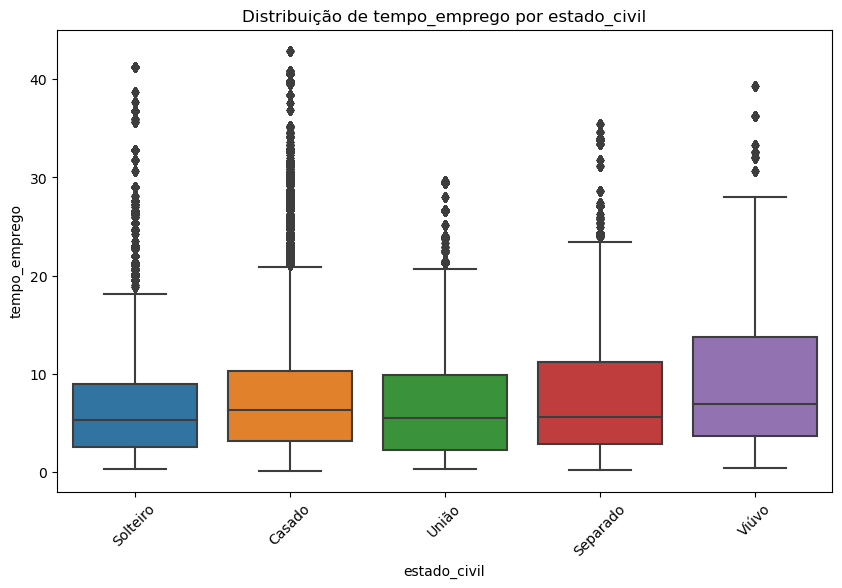

ANOVA entre estado_civil e tempo_emprego: F=nan, p=nan


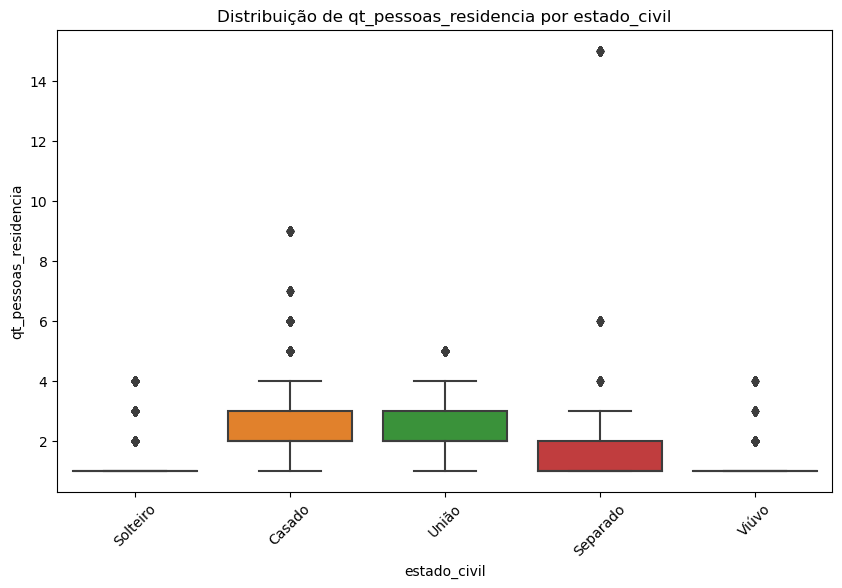

ANOVA entre estado_civil e qt_pessoas_residencia: F=100417.0950, p=0.0000


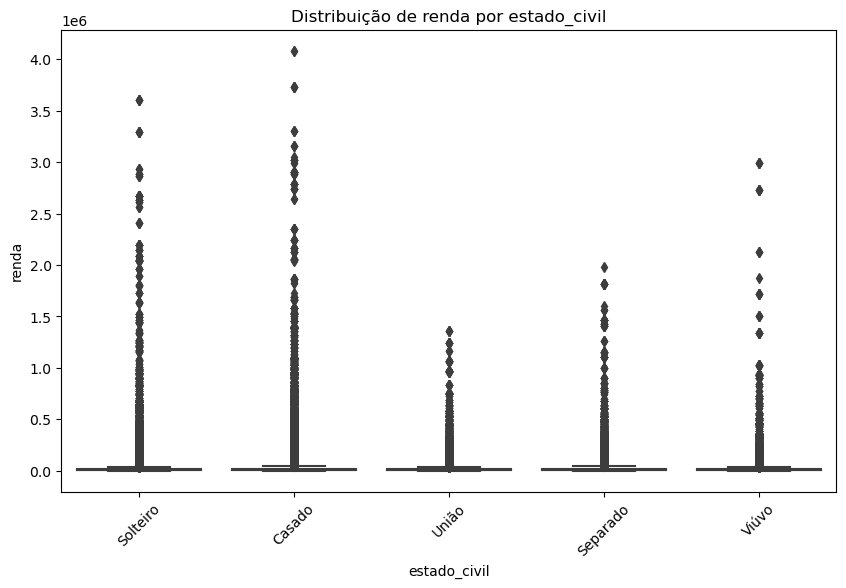

ANOVA entre estado_civil e renda: F=180.8409, p=0.0000


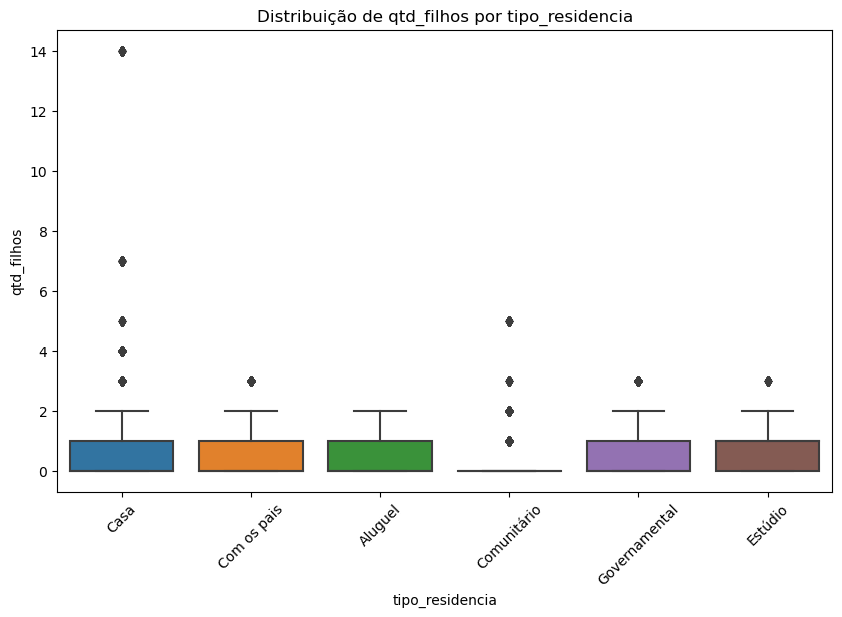

ANOVA entre tipo_residencia e qtd_filhos: F=308.4572, p=0.0000


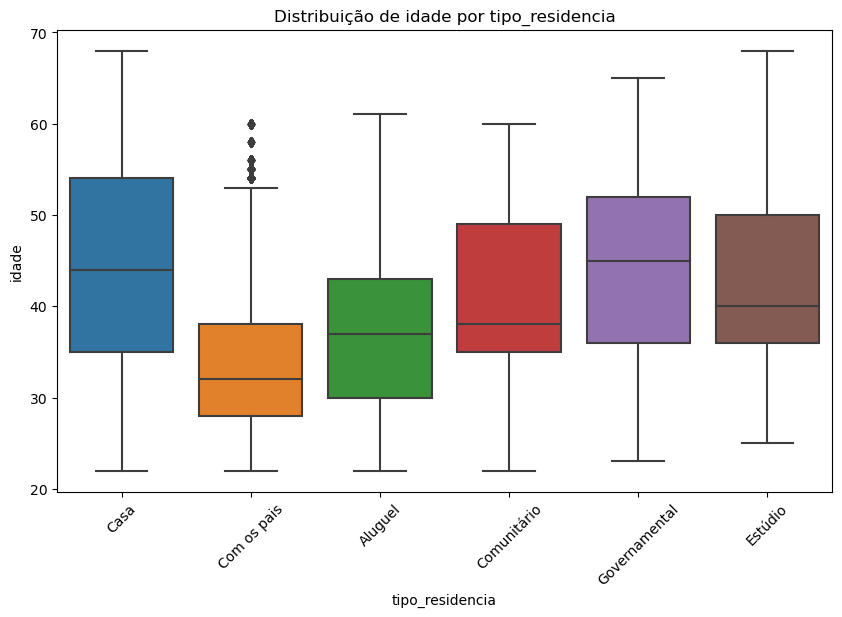

ANOVA entre tipo_residencia e idade: F=6387.4832, p=0.0000


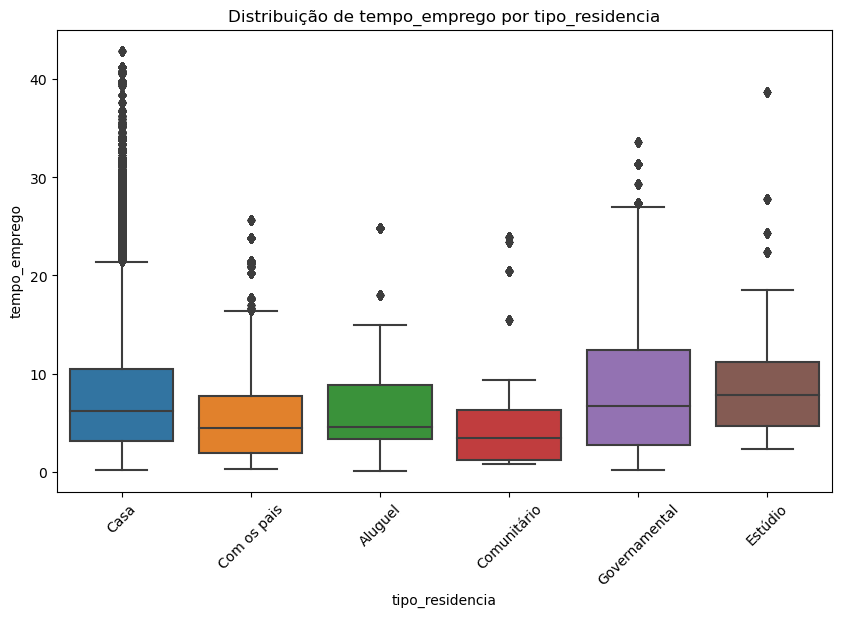

ANOVA entre tipo_residencia e tempo_emprego: F=nan, p=nan


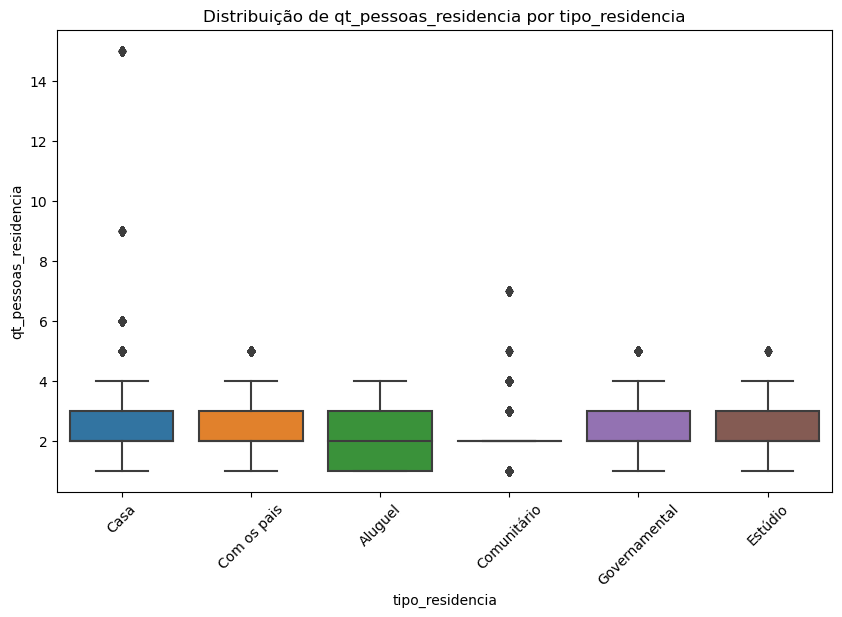

ANOVA entre tipo_residencia e qt_pessoas_residencia: F=208.7193, p=0.0000


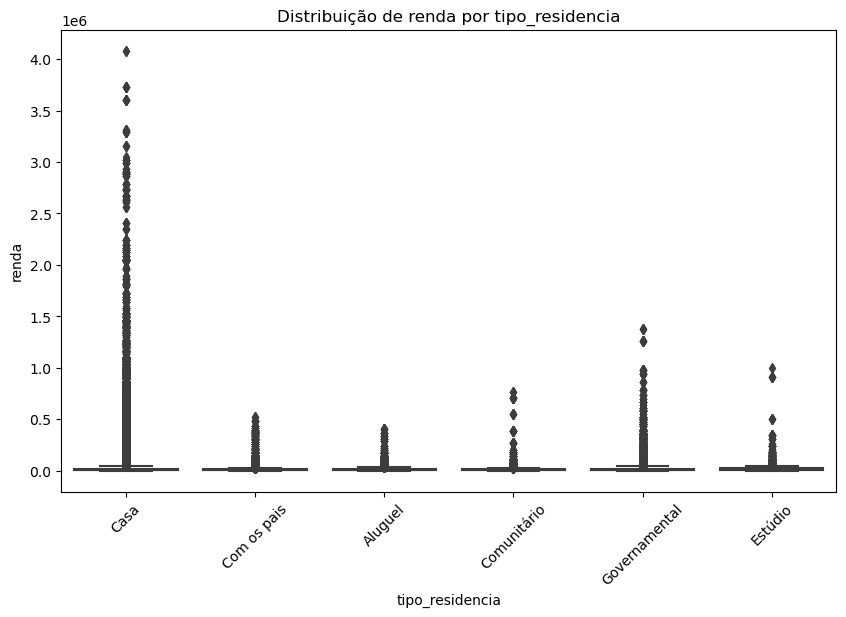

ANOVA entre tipo_residencia e renda: F=136.2828, p=0.0000


In [7]:
# Análise entre Variáveis Qualitativas e Quantitativas

for qual_var in qual_vars:
    for quant_var in quant_vars:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=qual_var, y=quant_var)
        plt.title(f"Distribuição de {quant_var} por {qual_var}")
        plt.xlabel(qual_var)
        plt.ylabel(quant_var)
        plt.xticks(rotation=45)
        plt.show()

        # Teste de ANOVA para verificar diferenças significativas
        groups = [df[df[qual_var] == category][quant_var] for category in df[qual_var].unique()]
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"ANOVA entre {qual_var} e {quant_var}: F={f_stat:.4f}, p={p_value:.4f}")

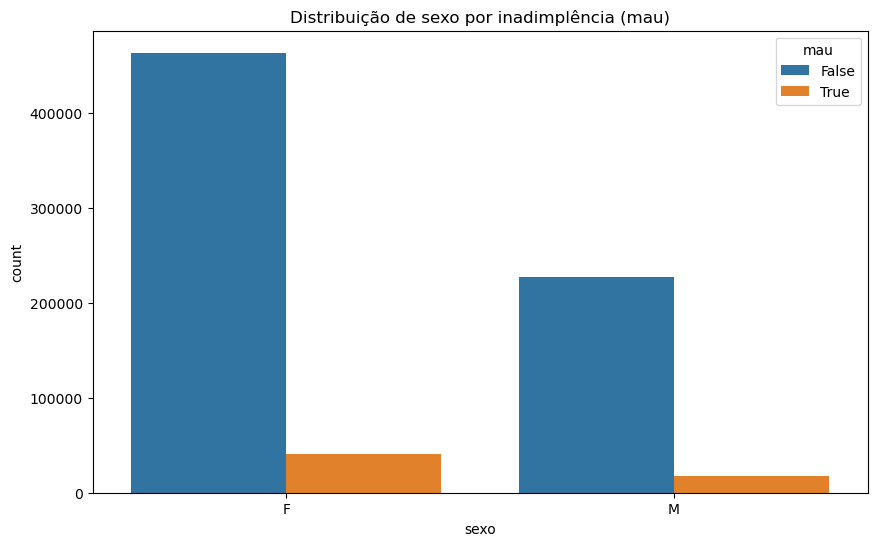

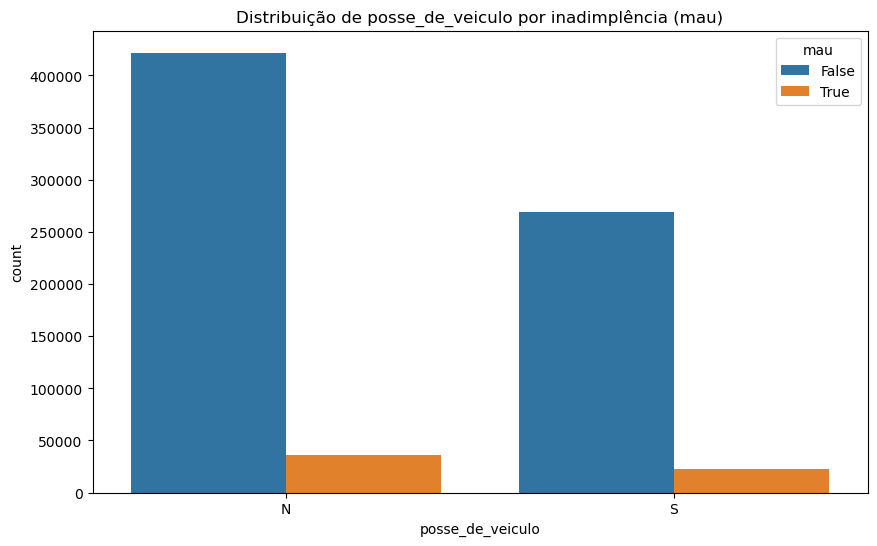

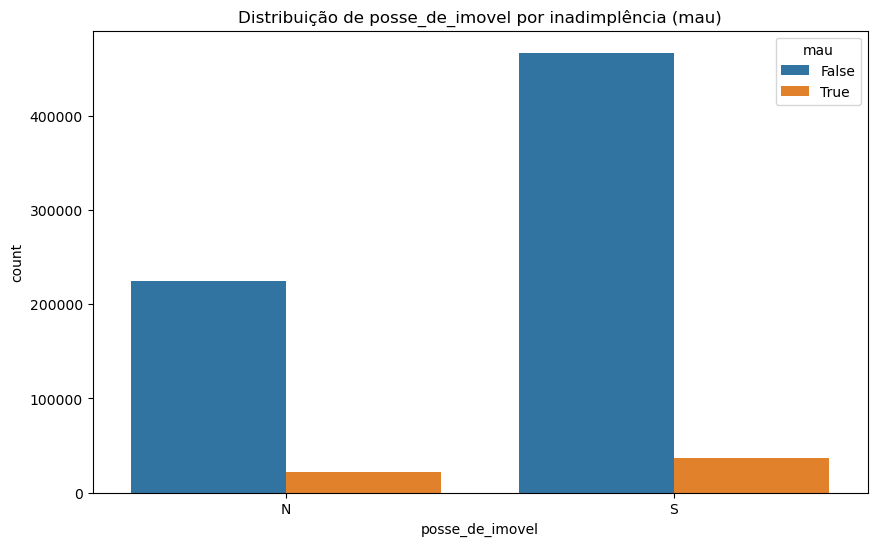

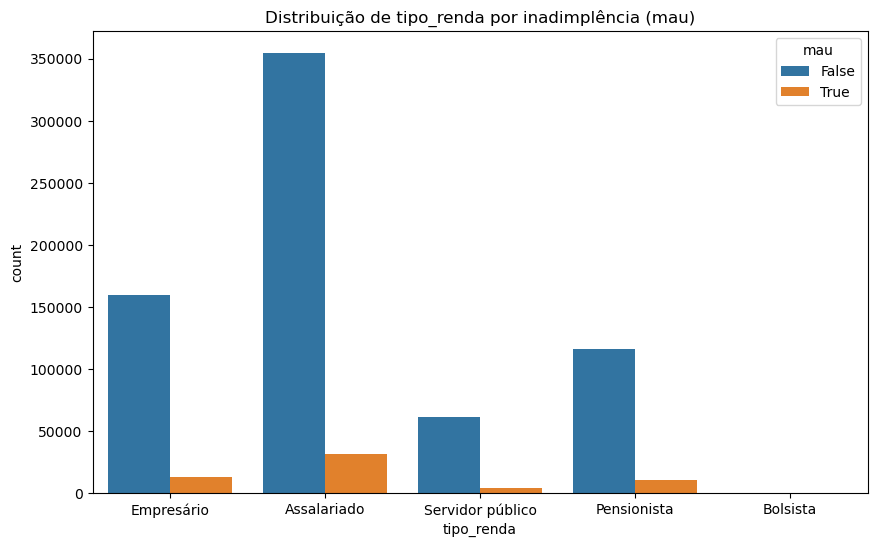

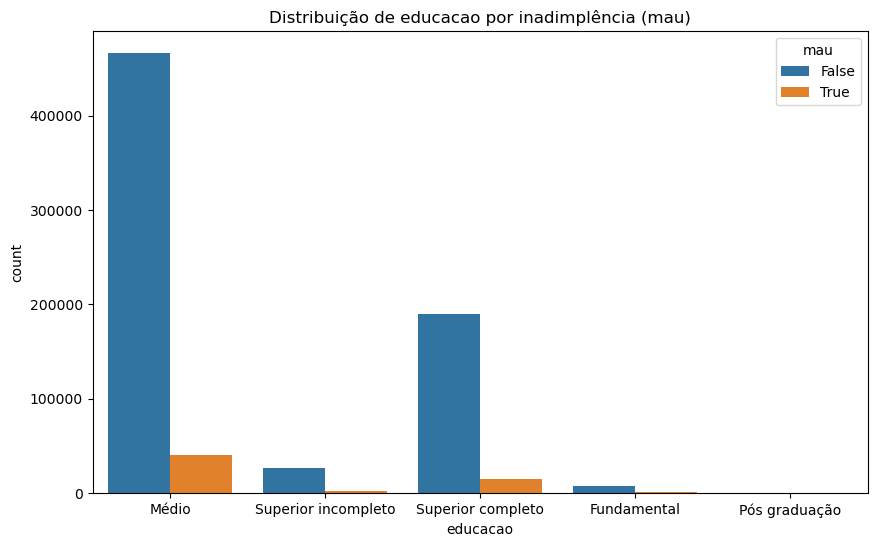

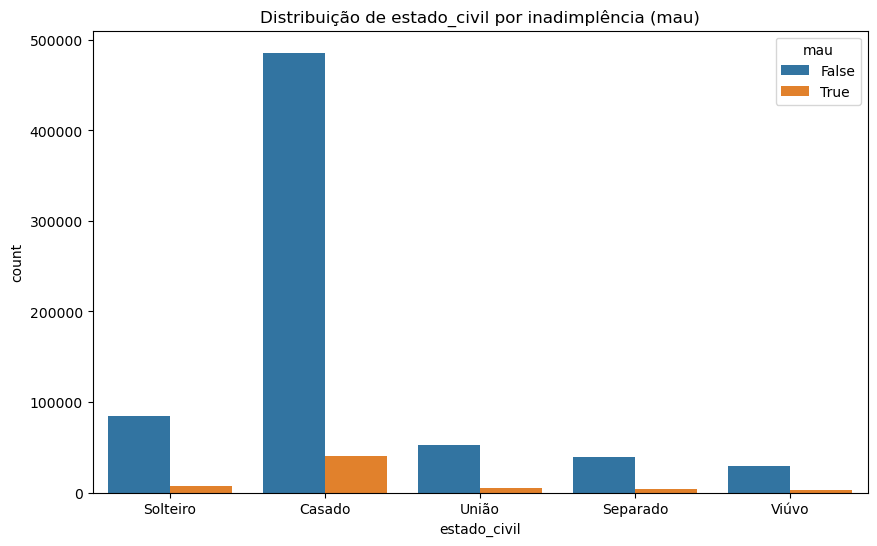

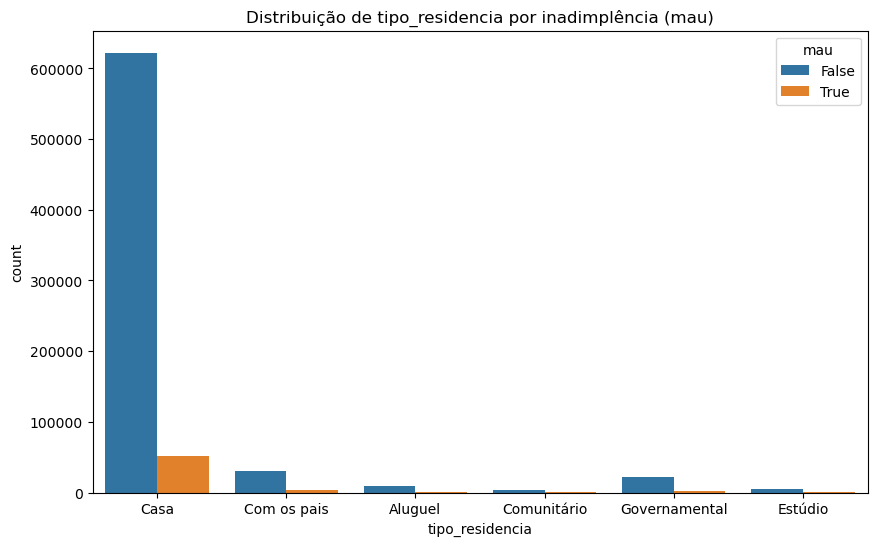

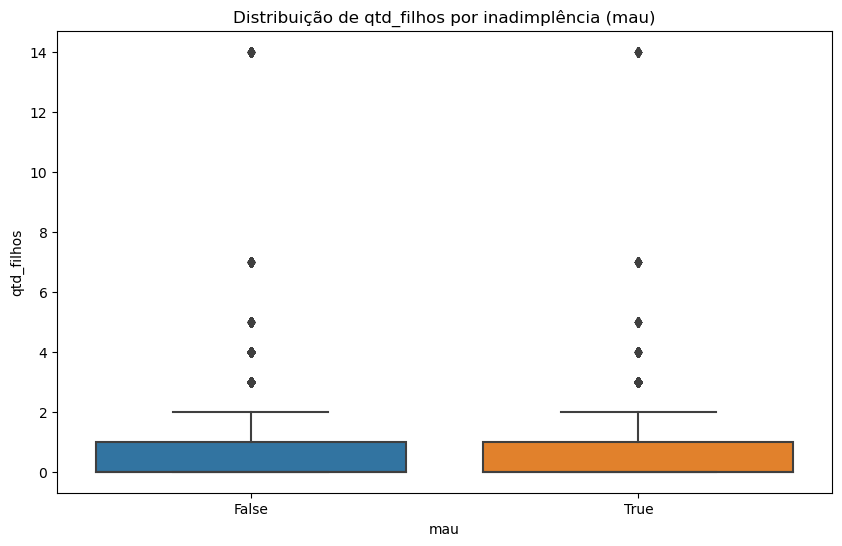

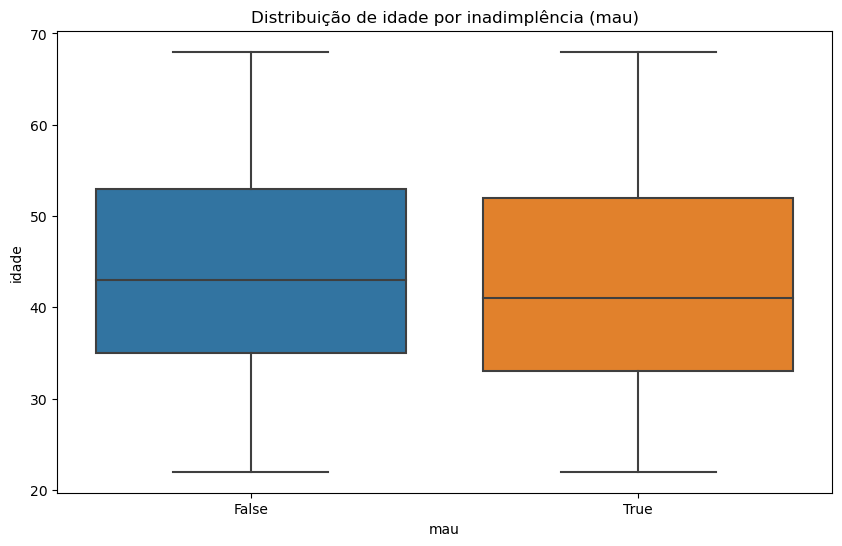

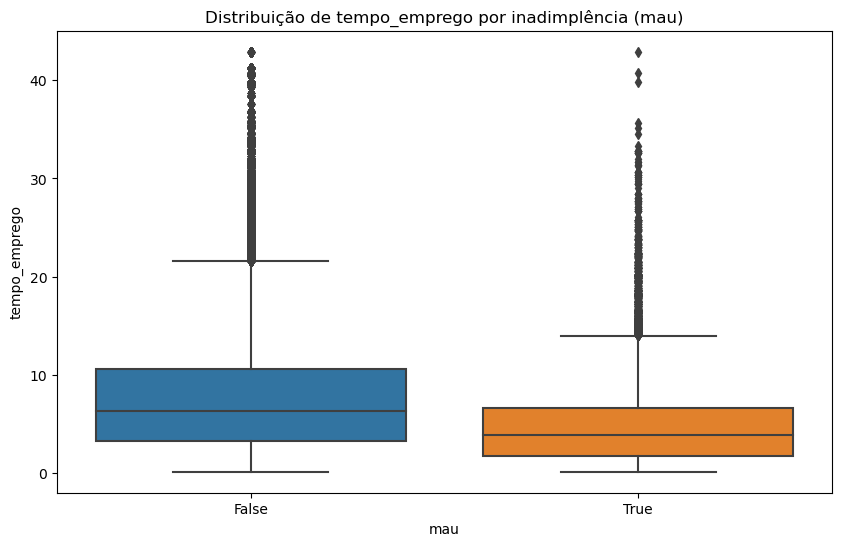

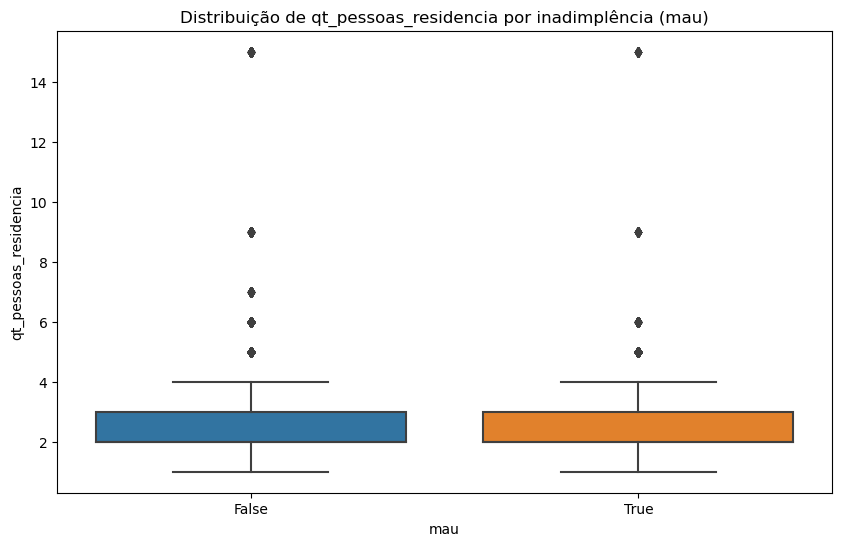

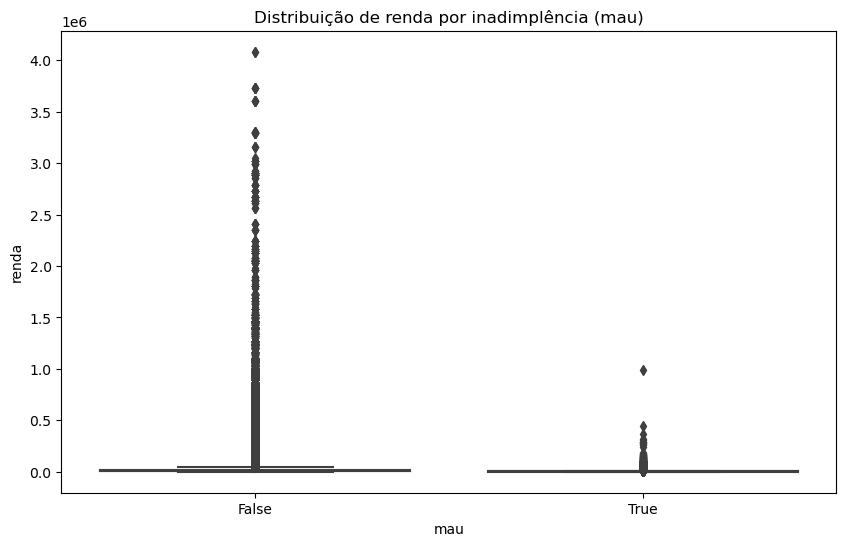

In [8]:
# Análise da variável dependente 'mau' com outras variáveis

# Entre variáveis qualitativas e a variável dependente
for qual_var in qual_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=qual_var, hue='mau')
    plt.title(f"Distribuição de {qual_var} por inadimplência (mau)")
    plt.show()

# Entre variáveis quantitativas e a variável dependente
for quant_var in quant_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='mau', y=quant_var)
    plt.title(f"Distribuição de {quant_var} por inadimplência (mau)")
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
from sklearn.impute import SimpleImputer

# Imputar valores ausentes na coluna 'tempo_emprego' com a mediana
imputer = SimpleImputer(strategy='median')
df['tempo_emprego'] = imputer.fit_transform(df[['tempo_emprego']])

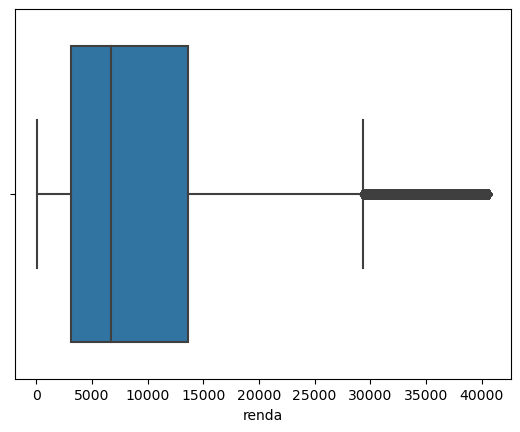

In [10]:
# Função para detectar outliers
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[col] < lower_bound) | (df[col] > upper_bound)

# Exemplo para a variável 'renda'
df['renda_outlier'] = detect_outliers(df, 'renda')

# Remover outliers
df = df[~df['renda_outlier']]
df.drop(columns='renda_outlier', inplace=True)

# Visualizar boxplot
sns.boxplot(x=df['renda'])
plt.show()

In [11]:
# Tratamento para zeros estruturais

# Para a variável 'tempo_emprego' única com zeros 
df['tempo_emprego'].replace(0, np.nan, inplace=True)  # Substituindo zeros por NaN para posterior imputação
df['tempo_emprego'] = imputer.fit_transform(df[['tempo_emprego']])


In [12]:
# Agrupamento de categorias para 'educacao'
df['educacao'] = df['educacao'].replace({
    'Ensino Médio': 'Educação Básica',
    'Ensino Superior': 'Educação Superior',
    'Pós-graduação': 'Educação Superior'
})


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Selecione suas variáveis independentes (X) e variável dependente (y)
X = df.drop(columns=['mau'])
y = df['mau']

# Defina as variáveis categóricas e numéricas
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
numerical_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Crie um pré-processador que codifica variáveis categóricas e escala variáveis numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Crie um pipeline que inclui o pré-processador e o modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Divida os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treine o modelo
model.fit(X_train, y_train)

# Faça previsões
y_pred = model.predict(X_test)

# Avalie o modelo
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Acurácia: 0.9130460703799204
              precision    recall  f1-score   support

       False       0.91      1.00      0.95    122518
        True       0.00      0.00      0.00     11668

    accuracy                           0.91    134186
   macro avg       0.46      0.50      0.48    134186
weighted avg       0.83      0.91      0.87    134186



C:\Users\Xam_j\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Xam_j\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Xam_j\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from sklearn.model_selection import train_test_split

# Desenvolvimento do modelo

# Separar variáveis independentes e dependentes
X = df.drop(columns=['data_ref', 'index', 'mau'])
y = df['mau']

# Convertendo variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Pré-processamento
X = df.drop(columns=['mau', 'data_ref', 'index'])  # Ajuste conforme necessário
y = df['mau']

# Definindo variáveis numéricas e categóricas
num_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
cat_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Definindo os pipelines para variáveis numéricas e categóricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputação para variáveis numéricas
    ('scaler', StandardScaler())  # Escalonamento
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputação para variáveis categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificação das categorias
])

# Combina os pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Cria o pipeline final sem o SMOTE
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar o pré-processamento aos dados de treinamento
X_train_preprocessed = preprocessor.fit_transform(X_train)
# Aplicar o SMOTE apenas aos dados de treinamento processados
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Ajustar o pipeline para incluir o pré-processamento e o modelo
pipeline.named_steps['classifier'].fit(X_train_res, y_train_res)

# Aplicar o pré-processamento nos dados de teste
X_test_preprocessed = preprocessor.transform(X_test)

# Avaliação
y_pred = pipeline.named_steps['classifier'].predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))




              precision    recall  f1-score   support

       False       0.97      0.56      0.71    122518
        True       0.15      0.81      0.25     11668

    accuracy                           0.58    134186
   macro avg       0.56      0.68      0.48    134186
weighted avg       0.90      0.58      0.67    134186



Variáveis não significativas: Se o valor p de uma variável for alto (acima de 0.05), pode ser considerada não significativa e removida, desde que não afete a interpretação do modelo ou a performance.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [20]:
from sklearn.model_selection import train_test_split

# Suponha que df seja o seu DataFrame e 'mau' seja a variável alvo
X = df.drop(columns=['mau'])
y = df['mau']

# Divida os dados em desenvolvimento e out-of-time
X_dev, X_oot, y_dev, y_oot = train_test_split(X, y, test_size=0.2, random_state=42)

# Divida ainda o conjunto de desenvolvimento em treinamento e validação (se necessário)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import numpy as np

# Defina o pré-processador e o pipeline do modelo
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
numerical_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Treine o modelo com o conjunto de treinamento
model.fit(X_train, y_train)

# Faça previsões para os conjuntos de validação e out-of-time
y_pred_val = model.predict(X_val)
y_pred_oot = model.predict(X_oot)

# Obtenha as probabilidades para as métricas KS e Gini
y_proba_val = model.predict_proba(X_val)[:, 1]
y_proba_oot = model.predict_proba(X_oot)[:, 1]


In [22]:
# Acurácia
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_oot = accuracy_score(y_oot, y_pred_oot)

print(f'Acurácia (Validação): {accuracy_val}')
print(f'Acurácia (Out-of-Time): {accuracy_oot}')

# KS
def calculate_ks(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    ks_statistic = np.max(tpr - fpr)
    return ks_statistic

ks_val = calculate_ks(y_val, y_proba_val)
ks_oot = calculate_ks(y_oot, y_proba_oot)

print(f'KS (Validação): {ks_val}')
print(f'KS (Out-of-Time): {ks_oot}')

# Índice de Gini
def calculate_gini(y_true, y_scores):
    auc = roc_auc_score(y_true, y_scores)
    return 2 * auc - 1

gini_val = calculate_gini(y_val, y_proba_val)
gini_oot = calculate_gini(y_oot, y_proba_oot)

print(f'Gini (Validação): {gini_val}')
print(f'Gini (Out-of-Time): {gini_oot}')


Acurácia (Validação): 0.9142889081407373
Acurácia (Out-of-Time): 0.9130460703799204
KS (Validação): 0.3912717688752528
KS (Out-of-Time): 0.38707611309244466
Gini (Validação): 0.5217467925499875
Gini (Out-of-Time): 0.5128144561834249


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Definir colunas categóricas e numéricas
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
numeric_features = ['tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Definir transformadores para cada tipo de dado
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Substitui valores nulos pela média
    ('scaler', StandardScaler())                  # Normaliza variáveis numéricas
])

# Definir o pré-processamento para cada coluna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [24]:
# Obter os nomes das colunas após a codificação one-hot
df_processed = preprocessor.fit_transform(df)
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Transformar o array de volta em um DataFrame
df_processed = pd.DataFrame(df_processed, columns=all_feature_names)


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [26]:
from scipy import stats

def remove_outliers(df, numeric_features, threshold=3.0):
    z_scores = stats.zscore(df[numeric_features].dropna())
    abs_z_scores = np.abs(z_scores)
    filter_outliers = (abs_z_scores < threshold).all(axis=1)
    return df[filter_outliers]


In [27]:
# Remover outliers antes do pré-processamento
df_cleaned = remove_outliers(df, numeric_features)

# Aplicar o pipeline de pré-processamento ao DataFrame limpo
df_processed = preprocessor.fit_transform(df_cleaned)


In [28]:
# Obter os nomes das colunas após a codificação one-hot
df_processed = preprocessor.fit_transform(df)
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Transformar o array de volta em um DataFrame
df_processed = pd.DataFrame(df_processed, columns=all_feature_names)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

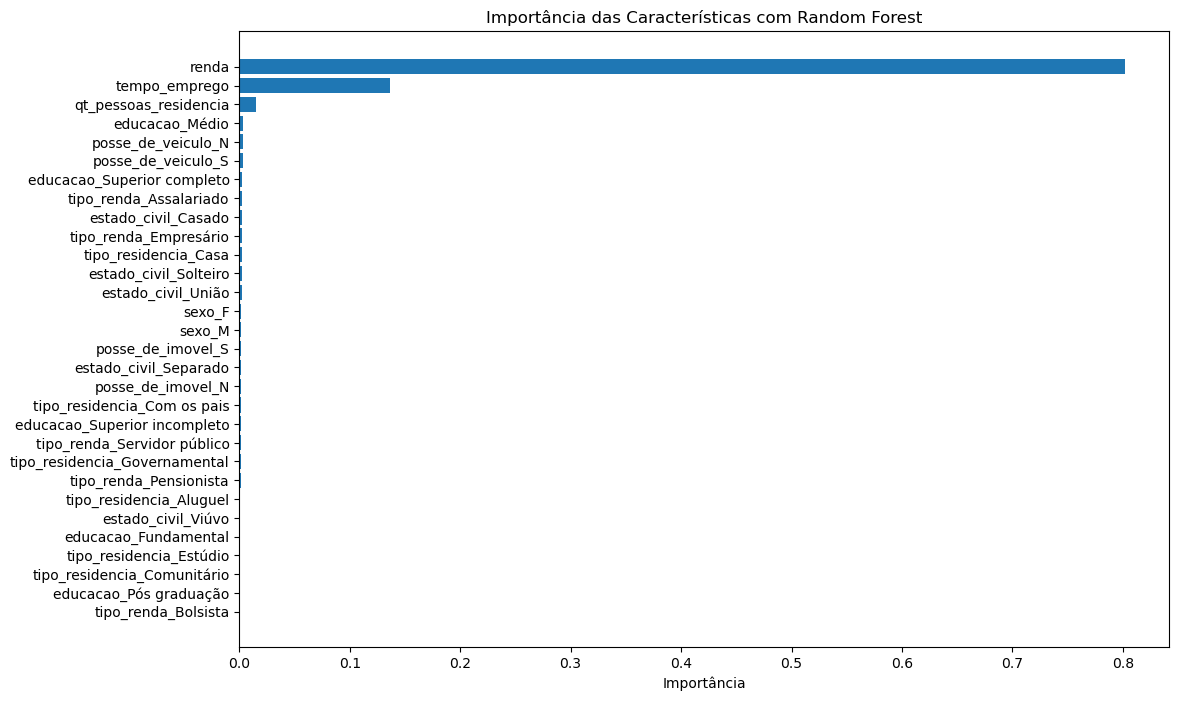

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Aplicar o pipeline de pré-processamento ao DataFrame limpo
X_processed = preprocessor.fit_transform(df_cleaned)
y = df_cleaned['mau']  # Ajuste isso se a variável alvo for diferente

# Treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_processed, y)

# Obter importâncias das características
importances = model.feature_importances_

# Obter nomes das características após a codificação one-hot
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Criar DataFrame com importâncias das características
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.title('Importância das Características com Random Forest')
plt.gca().invert_yaxis()  # Inverter o eixo y para que as características mais importantes fiquem no topo
plt.show()

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

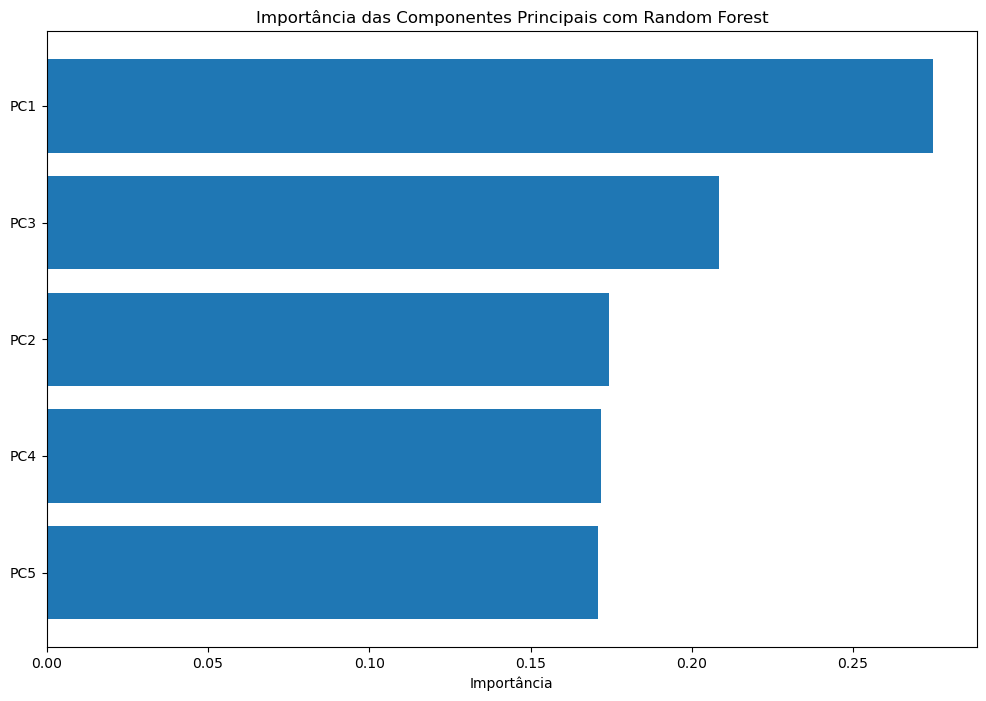

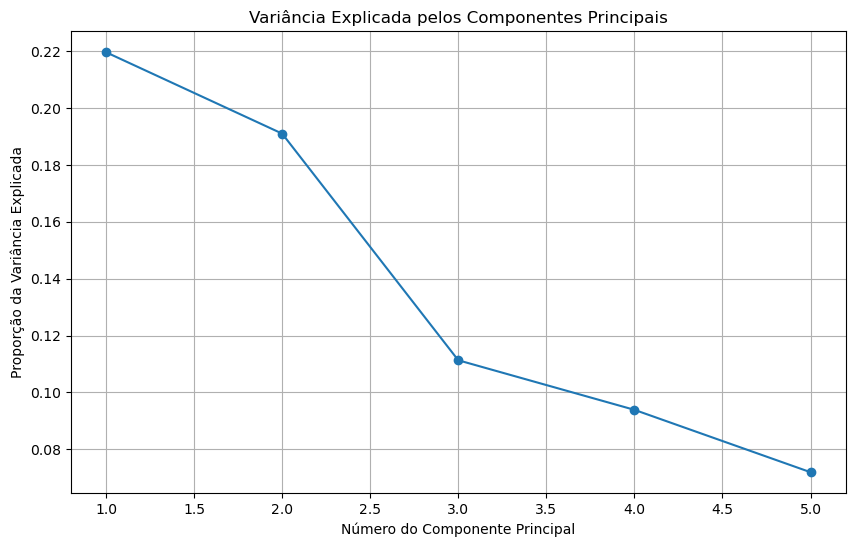

In [30]:
from sklearn.decomposition import PCA

# Pipeline de pré-processamento + PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))  # Reduzir para 5 componentes principais
])

# Aplicar o pipeline ao DataFrame limpo
X_processed_pca = pipeline.fit_transform(df_cleaned)
y = df_cleaned['mau']  # Ajuste isso se a variável alvo for diferente

# Treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_processed_pca, y)

# Obter importâncias das características após PCA
importances = model.feature_importances_

# Obter o nome das componentes principais
pca = pipeline.named_steps['pca']
components = pca.components_

# Criar DataFrame com importâncias das características
# Nota: Após PCA, as características são componentes principais, então a interpretação é diferente.
feature_importance_df = pd.DataFrame({
    'Feature': [f'PC{i+1}' for i in range(5)],  # Nomes das componentes principais
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.title('Importância das Componentes Principais com Random Forest')
plt.gca().invert_yaxis()  # Inverter o eixo y para que as características mais importantes fiquem no topo
plt.show()

# Visualizar a variância explicada pelos componentes principais
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), explained_variance, marker='o')
plt.xlabel('Número do Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.grid(True)
plt.show()

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [31]:
# Tornando as variaveis categoricas em dummies
df_encoded = pd.get_dummies(df, columns=[
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
    'educacao', 'estado_civil', 'tipo_residencia'
])

df_encoded

data_ref  index  qtd_filhos  idade  tempo_emprego  \
0      2015-01-01   5733           0     43       6.873973   
1      2015-01-01    727           0     35       4.526027   
2      2015-01-01   6374           2     31       0.243836   
3      2015-01-01   9566           0     54      12.772603   
4      2015-01-01   9502           0     31       8.432877   
...           ...    ...         ...    ...            ...   
749995 2016-03-01  13689           0     48       3.038356   
749996 2016-03-01   7000           0     65       6.046575   
749997 2016-03-01  14023           2     43      10.375342   
749998 2016-03-01   2396           0     56      13.780822   
749999 2016-03-01  14026           2     43      10.375342   

        qt_pessoas_residencia     renda    mau  sexo_F  sexo_M  ...  \
0                         1.0   2515.39  False    True   False  ...   
1                         2.0   3180.19  False    True   False  ...   
2                         4.0   1582.29  False    True   False  ...   
3                         2.0  13721.17  False    True   False  ...   
4                         1.0   2891.08  False    True   False  ...   
...                       ...       ...    ...     ...     ...  ...   
749995                    2.0   2109.99  False   False    True  ...   
749996                    1.0   1389.39  False    True   False  ...   
749997                    4.0    649.06   True   False    True  ...   
749998                    1.0   4216.72   True    True   False  ...   
749999                    4.0   4460.69  False   False    True  ...   

        estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0                       False                   True               False   
1                       False                  False               False   
2                       False                  False               False   
3                       False                  False               False   
4                       False                   True               False   
...                       ...                    ...                 ...   
749995                  False                  False               False   
749996                  False                   True               False   
749997                  False                  False               False   
749998                  False                  False               False   
749999                  False                  False               False   

        estado_civil_Viúvo  tipo_residencia_Aluguel  tipo_residencia_Casa  \
0                    False                    False                  True   
1                    False                    False                  True   
2                    False                    False                  True   
3                    False                    False                  True   
4                    False                    False                  True   
...                    ...                      ...                   ...   
749995               False                    False                  True   
749996               False                    False                  True   
749997               False                    False                  True   
749998                True                    False                  True   
749999               False                    False                  True   

        tipo_residencia_Com os pais  tipo_residencia_Comunitário  \
0                             False                        False   
1                             False                        False   
2                             False                        False   
3                             False                        False   
4                             False                        False   
...                             ...                          ...   
749995                        False                        False   
749996                       

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [32]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
df_encoded = pd.get_dummies(data, columns=[
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
    'educacao', 'estado_civil', 'tipo_residencia'
])
print('Conjunto de dados para modelagem (treino e teste): ' + str(df_encoded.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(df_encoded.shape))


Conjunto de dados para modelagem (treino e teste): (637382, 35)
Conjunto de dados não usados no treino/teste, apenas como validação: (637382, 35)


In [33]:
from pycaret.classification import *

In [34]:
df_encoded.dtypes

data_ref                         datetime64[ns]
index                                     int64
qtd_filhos                                int64
idade                                     int64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                        bool
sexo_F                                     bool
sexo_M                                     bool
posse_de_veiculo_N                         bool
posse_de_veiculo_S                         bool
posse_de_imovel_N                          bool
posse_de_imovel_S                          bool
tipo_renda_Assalariado                     bool
tipo_renda_Bolsista                        bool
tipo_renda_Empresário                      bool
tipo_renda_Pensionista                     bool
tipo_renda_Servidor público                bool
educacao_Fundamental                       bool
educacao_Médio                          

In [35]:
df_encoded.corr()

data_ref     index  qtd_filhos     idade  \
data_ref                       1.000000 -0.002170   -0.002797  0.004082   
index                         -0.002170  1.000000    0.028790 -0.046242   
qtd_filhos                    -0.002797  0.028790    1.000000 -0.366317   
idade                          0.004082 -0.046242   -0.366317  1.000000   
tempo_emprego                  0.037293 -0.023415   -0.007039  0.134085   
qt_pessoas_residencia         -0.002561  0.029175    0.892467 -0.335934   
renda                         -0.151636 -0.019399   -0.011865  0.059278   
mau                            0.067475  0.008397    0.003728 -0.020052   
sexo_F                         0.000808 -0.026533   -0.109917  0.212220   
sexo_M                        -0.000808  0.026533    0.109917 -0.212220   
posse_de_veiculo_N             0.000903  0.012972   -0.116176  0.170209   
posse_de_veiculo_S            -0.000903 -0.012972    0.116176 -0.170209   
posse_de_imovel_N             -0.001238  0.108448    0.012055 -0.133548   
posse_de_imovel_S              0.001238 -0.108448   -0.012055  0.133548   
tipo_renda_Assalariado         0.002141  0.027593    0.146804 -0.297310   
tipo_renda_Bolsista            0.002113 -0.034710   -0.012808  0.014262   
tipo_renda_Empresário          0.001285 -0.002168    0.024091 -0.192792   
tipo_renda_Pensionista        -0.007211 -0.035171   -0.254282  0.654243   
tipo_renda_Servidor público    0.004262  0.005543    0.056828 -0.088540   
educacao_Fundamental          -0.002413 -0.012047   -0.027472  0.049348   
educacao_Médio                 0.000990  0.000411   -0.058074  0.198401   
educacao_Pós graduação        -0.001182  0.000287    0.012756 -0.006697   
educacao_Superior completo    -0.000072  0.009061    0.055672 -0.152974   
educacao_Superior incompleto  -0.000644 -0.014708    0.025653 -0.152882   
estado_civil_Casado           -0.001030  0.014866    0.149199 -0.038892   
estado_civil_Separado         -0.001104 -0.021771   -0.017869  0.052602   
estado_civil_Solteiro          0.002771  0.019200   -0.131318 -0.077233   
estado_civil_União             0.001315 -0.006532   -0.000051 -0.058456   
estado_civil_Viúvo            -0.002654 -0.031569   -0.104800  0.231515   
tipo_residencia_Aluguel        0.002085 -0.013465   -0.000342 -0.065825   
tipo_residencia_Casa           0.000427 -0.018725   -0.027064  0.156104   
tipo_residencia_Com os pais   -0.003625  0.021115    0.035236 -0.186684   
tipo_residencia_Comunitário   -0.001788  0.004082   -0.000988 -0.018194   
tipo_residencia_Estúdio        0.001045  0.013385    0.027831 -0.009861   
tipo_residencia_Governamental  0.002442  0.008421   -0.008339  0.010405   

                               tempo_emprego  qt_pessoas_residencia     renda  \
data_ref                            0.037293              -0.002561 -0.151636   
index                              -0.023415               0.029175 -0.019399   
qtd_filhos                         -0.007039               0.892467 -0.011865   
idade                               0.134085              -0.335934  0.059278   
tempo_emprego                       1.000000               0.011808  0.397950   
qt_pessoas_residencia               0.011808               1.000000 -0.000993   
renda                               0.397950              -0.000993  1.000000   
mau                                -0.098727               0.000416 -0.190976   
sexo_F                              0.043378              -0.146267 -0.035316   
sexo_M                             -0.043378               0.146267  0.035316   
posse_de_veiculo_N                  0.019608              -0.166470 -0.018689   
posse_de_veiculo_S                 -0.019608               0.166470  0.018689   
posse_de_imovel_N                   0.023404               0.013056 -0.055698   
posse_de_imovel_S                  -0.023404              -0.013056  0.055698   
tipo_renda_Assalariado              0.021147               0.142372 -0.017900   
tipo_renda_Bolsista               

In [36]:
data = df_encoded

In [37]:
data.mau.value_counts(normalize=True)

mau
False    0.91319
True     0.08681
Name: proportion, dtype: float64

In [38]:
exp_aula4 = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)



### Treinar um modelo de regressão logistica com o resultado

In [40]:
# Definir o pré-processador
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
numerical_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Defina o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Crie o pipeline com o modelo de Regressão Logística
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Treine o modelo
pipeline.fit(X_train, y_train)

# Faça previsões
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]


In [41]:
# Acurácia
accuracy = accuracy_score(y_test, y_pred)

# AUC (Área sob a curva ROC)
auc_score = roc_auc_score(y_test, y_proba)

# Relatório de Classificação
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'AUC: {auc_score}')
print('Relatório de Classificação:')
print(classification_rep)

# Cálculo do KS
def calculate_ks(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    ks_statistic = np.max(tpr - fpr)
    return ks_statistic

ks_score = calculate_ks(y_test, y_proba)
print(f'KS: {ks_score}')


Acurácia: 0.571505224091932
AUC: 0.755367686718228
Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.55      0.70    122518
        True       0.15      0.81      0.25     11668

    accuracy                           0.57    134186
   macro avg       0.56      0.68      0.47    134186
weighted avg       0.90      0.57      0.66    134186

KS: 0.38608052571741075


In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best AUC Score: {grid_search.best_score_}')


Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Best AUC Score: 0.7539931991486178


### Salvar o pickle file do modelo treinado

In [43]:
import pickle

nome_arquivo = 'modelo_regressao_logistica.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))


In [46]:
# Salve o modelo
with open(nome_arquivo, 'wb') as file:
    pickle.dump(pipeline, file)

print(f'Modelo salvo em {nome_arquivo}')


Modelo salvo em modelo_regressao_logistica.pkl


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

In [48]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [49]:
from pycaret.classification import *
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [50]:
df = df.drop('index', axis=1)

# Converter 'data_ref' para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Separar os três últimos meses para validação *out of time*
last_three_months = df['data_ref'].max() - pd.DateOffset(months=3)
dataset = df[df['data_ref'] > last_three_months]
train_df = df[df['data_ref'] < last_three_months]

dataset['data_ref'].unique()


<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Dividir o DataFrame em Variáveis Independentes
X = data.drop(columns=['data_ref', 'renda'])
y = data['renda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Definir o Imputer para lidar com valores faltantes
imputer = SimpleImputer(strategy='mean')  # Substitui valores faltantes pela média

# Define o PCA para redução de dimensionalidade linear
pca = PCA(n_components=5)

# Define o Standard Scaler para normalizar os dados
scaler = StandardScaler()

# Define a Regressão Linear
linear_reg = LinearRegression()

# "Fitando" e aplicando o Imputer nos dados de treino
imputer.fit(X_train)
X_train = imputer.transform(X_train)

# "Fitando" e aplicando o Standard Scaler nos dados de treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# "Fitando" e aplicando o PCA nos dados de treino
pca.fit(X_train)
X_train = pca.transform(X_train)

# "Fitando" e predizendo uma regressão linear nos dados de treino
linear_reg.fit(X_train, y_train)

# Predizendo nos dados de treino
y_train_pred = linear_reg.predict(X_train)

# Aplicando o Imputer, Standard Scaler e PCA nos dados de teste
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

# Predizendo nos dados de teste
y_test_pred = linear_reg.predict(X_test)

print("Previsões no conjunto de treino:\n", y_train_pred)
print("Previsões no conjunto de teste:\n", y_test_pred)

Previsões no conjunto de treino:
 [10249.25618898  9500.67659418  9757.07603164 ... 10184.97834708
  8973.85590029  9697.25220229]
Previsões no conjunto de teste:
 [ 9464.45867696  9361.12197093 10789.01483562 ...  9971.75067843
  8699.95617688  9340.50762995]


In [52]:
# Criar o Pipeline com os passos definidos
pipe = Pipeline(steps=[
    ("imputer", imputer), 
    ("scaler", scaler), 
    ("pca", pca), 
    ("linear_reg", linear_reg)
])

# Verificar os passos do Pipeline
print(pipe.named_steps)


{'imputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              keep_empty_features=False, missing_values=nan, strategy='mean'), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=5, n_oversamples=10,
    power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
    tol=0.0, whiten=False), 'linear_reg': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, positive=False)}


In [53]:
from pycaret.classification import compare_models

# Ordenar os modelos com base na métrica de avaliação 'Accuracy'
best_model = compare_models(fold=10, sort='Accuracy')


In [54]:
lightgbm = create_model('lightgbm')

In [55]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


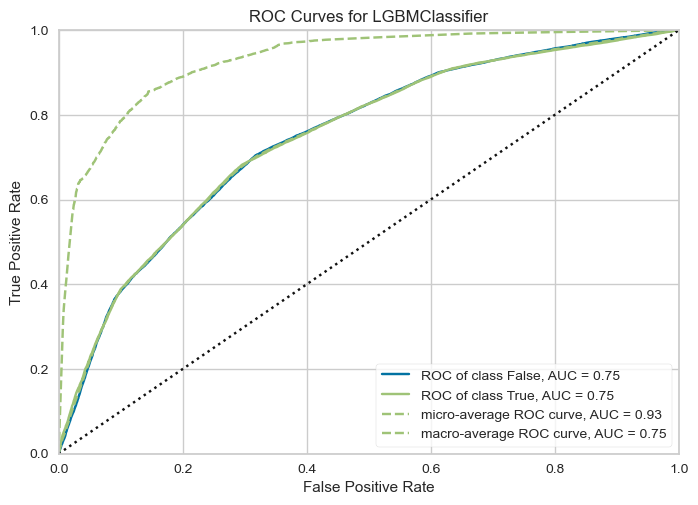

In [56]:
from pycaret.classification import plot_model

# Plotar a Curva ROC para o modelo ajustado
plot_model(tuned_lightgbm, plot='auc')


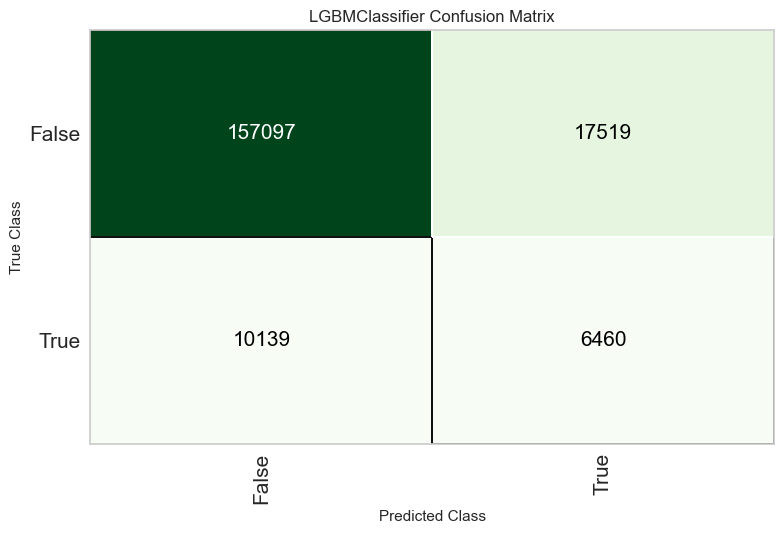

In [57]:
# Plotar a Matriz de Confusão para o modelo ajustado
plot_model(tuned_lightgbm, plot='confusion_matrix')


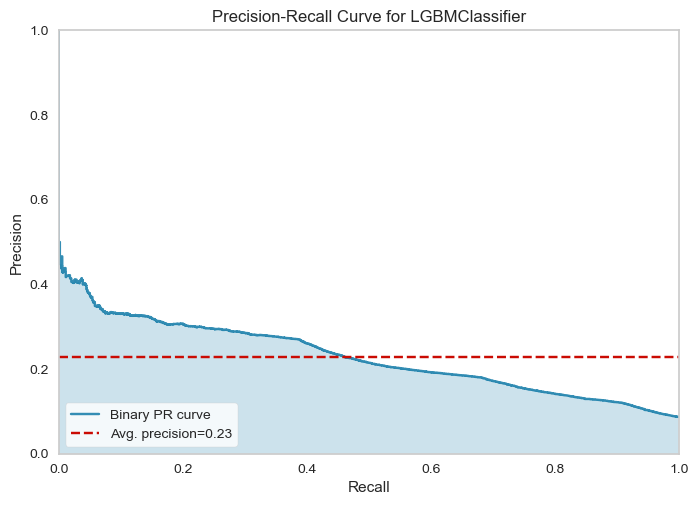

In [58]:
plot_model(tuned_lightgbm, plot = 'pr')

In [59]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
xxx = create_model('xxx')

### Salvar o arquivo do modelo treinado

In [61]:
# Salve o modelo
filename = 'modelo_regressao_logistica.pkl'
with open(filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f'Modelo salvo em {filename}')

Modelo salvo em modelo_regressao_logistica.pkl


# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.